In [ ]:
!pip install nb-black

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [3]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [6]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [7]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [8]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [9]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Investigating Whitening Methods

In [10]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [11]:
signal = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signal.append(sig)
    label.append(lbl["label"])
signal = torch.vstack(signal)
label = torch.stack(label)

  0%|          | 0/2592 [00:00<?, ?it/s]

In [12]:
signal.size(), label.size()

(torch.Size([2592, 22, 1, 1, 1001]), torch.Size([2592]))

In [14]:
import matplotlib.pyplot as plt
import scipy.linalg as la

In [15]:
def calc_cov(EEG_data):
    """
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    """
    cov = []
    for i in range(EEG_data.size()[0]):
        cov.append(
            EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
        )

    cov = torch.mean(torch.stack(cov), 0)

    return cov

In [16]:
x = signal.squeeze()
sig = x.permute(0, 2, 1)
x = torch.mean(sig, axis=1)
x_mean = torch.mean(x, axis=0)
sig.size(), x_mean.size()

(torch.Size([2592, 1001, 22]), torch.Size([22]))

In [17]:
x = sig - x_mean
x_zero_centered = x.permute(0, 2, 1)
x_zero_centered.size()

torch.Size([2592, 22, 1001])

In [18]:
x = x_zero_centered
x_cov = calc_cov(x)
x_cov.shape

torch.Size([22, 22])

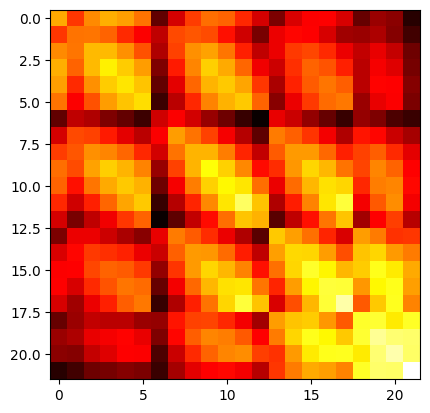

In [19]:
plt.imshow(x_cov, cmap="hot", interpolation="nearest")
plt.show()

In [20]:
lda, V = torch.linalg.eig(x_cov)
lda, V = lda.real, V.real
whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
# print(torch.allclose(whitening_mat, torch.sqrt(torch.inverse(x_cov))))
# whitening_mat = torch.inverse(torch.sqrt(x_cov))

whitening_mat.size()

torch.Size([22, 22])

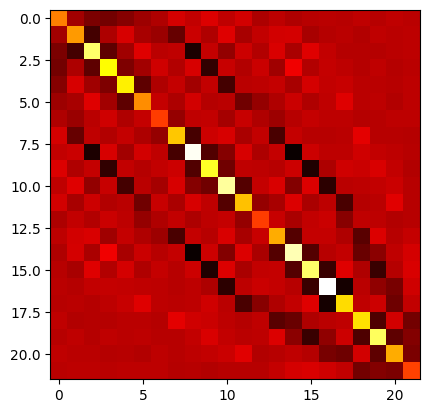

In [21]:
plt.imshow(whitening_mat, cmap="hot", interpolation="nearest")
plt.show()

In [22]:
whitened_signal = whitening_mat @ x_zero_centered
whitened_signal.size()

torch.Size([2592, 22, 1001])

In [23]:
x = whitened_signal
whitened_signal_cov = calc_cov(x)
whitened_signal_cov.shape

torch.Size([22, 22])

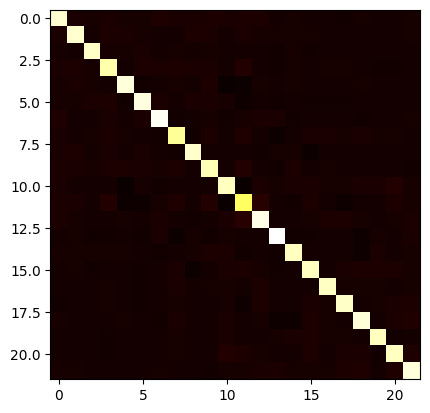

In [24]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

## Pytorch Dataset Transform Model

In [25]:
class Whitening:
    def __init__(self, data_loader, whitening_method="PCA"):
        self.ds = data_loader
        self.method = whitening_method

        self.W = self._generate_whitening_transformation(self.ds, self.method)

    def _generate_whitening_transformation(self, data_loader, whitening_method="PCA"):
        """extract whitening transformation from data

        Parameters
        ----------
        data_loader : torch.dataloader
            pytorch data loader
        whitening_method : str
            one of following values
            "PCA" for PCA whitening
            "ZCA for ZCA whitening

        Returns
        -------
        torch.Tensor
            whitening transformation matrix
        """
        # get data
        signal = []
        for sig, lbl in data_loader:
            signal.append(sig)
        signal = torch.vstack(signal)

        # zero center
        x = signal.squeeze()
        sig = x.permute(0, 2, 1)
        x = torch.mean(sig, axis=1)
        x_mean = torch.mean(x, axis=0)

        x = sig - x_mean
        x_zero_centered = x.permute(0, 2, 1)

        # Calculate whitening matrix
        x_cov = self._calc_cov(x_zero_centered)

        lda, V = torch.linalg.eig(x_cov)
        lda, V = lda.real, V.real
        if "PCA":
            whitening_mat = torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
        elif "ZCA":
            whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T

        return whitening_mat

    def _calc_cov(self, EEG_data):
        cov = []
        for i in range(EEG_data.size()[0]):
            cov.append(
                EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
            )

        cov = torch.mean(torch.stack(cov), 0)

        return cov

    def __call__(self, data: Tensor, label):
        whitened_data = self.W @ data
        return whitened_data, label

In [26]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[2],
)

In [27]:
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [29]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    Whitening(train_dataloader, whitening_method="ZCA"),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds_w = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[2],
)

In [30]:
ds_w[0][0].size()

torch.Size([1, 22, 1, 1, 1001])

In [31]:
# train_dataset, _ = ds_w.get_train_test_subsets()

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=1,
#     shuffle=False,
#     collate_fn=collate_fn,
#     num_workers=1,
# )

batch_size = 32
train_dataset, val_dataset = ds_w.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

In [32]:
signal = []
for sig, lbl in tqdm(train_dataloader):
    signal.append(sig)
signal = torch.vstack(signal)
signal.size()

  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([288, 22, 1, 1, 1001])

In [33]:
whitened_signal_cov = calc_cov(signal.squeeze())
whitened_signal_cov.shape

torch.Size([22, 22])

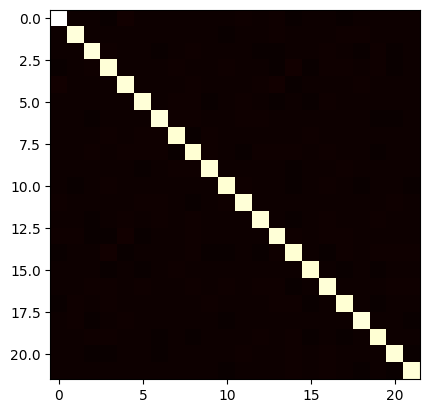

In [34]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

# Model

In [35]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

import torch.optim as optim

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [36]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [37]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [38]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [39]:
net = net.cuda()

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


9it [00:00, 17.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3946860631306965


Train -  [0.25, 0.0, 0.7236689814814814, 0.25, tensor(1.3858)]
Validation -  [0.25, 0.0, 0.5875530478395062, 0.25, tensor(1.3875)]

Epoch  1


9it [00:00, 34.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3997561269336276


Train -  [0.2534722222222222, 0.00462962962962965, 0.8037551440329218, 0.2534722222222222, tensor(1.3850)]
Validation -  [0.25, 0.0, 0.6491126543209876, 0.25, tensor(1.3886)]

Epoch  2


9it [00:00, 30.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.390414423412747


Train -  [0.2534722222222222, 0.00462962962962965, 0.8267264660493827, 0.2534722222222222, tensor(1.3845)]
Validation -  [0.25, 0.0, 0.6704443158436214, 0.25, tensor(1.3888)]

Epoch  3


9it [00:00, 36.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3911130958133273


Train -  [0.3854166666666667, 0.18055555555555558, 0.842994470164609, 0.38541666666666663, tensor(1.3755)]
Validation -  [0.3541666666666667, 0.13888888888888884, 0.6911490483539094, 0.3541666666666667, tensor(1.3812)]

Epoch  4


9it [00:00, 34.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.386942942937215


Train -  [0.2708333333333333, 0.02777777777777779, 0.8585873199588477, 0.2708333333333333, tensor(1.3762)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.722608024691358, 0.2534722222222222, tensor(1.3820)]

Epoch  5


9it [00:00, 35.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.402813778983222


Train -  [0.2916666666666667, 0.05555555555555558, 0.8225147890946503, 0.2916666666666667, tensor(1.3916)]
Validation -  [0.24305555555555555, -0.0092592592592593, 0.6615869341563785, 0.24305555555555555, tensor(1.3964)]

Epoch  6


9it [00:00, 33.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.389906817012363


Train -  [0.2743055555555556, 0.03240740740740744, 0.8718010545267489, 0.2743055555555556, tensor(1.3730)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.7400173611111112, 0.2569444444444444, tensor(1.3800)]

Epoch  7


9it [00:00, 35.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.382280773586697


Train -  [0.2534722222222222, 0.00462962962962965, 0.8714634773662552, 0.2534722222222222, tensor(1.3779)]
Validation -  [0.25, 0.0, 0.7531346450617284, 0.25, tensor(1.3841)]

Epoch  8


9it [00:00, 38.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3809082905451457


Train -  [0.2673611111111111, 0.02314814814814814, 0.8752732767489712, 0.2673611111111111, tensor(1.3733)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.7576999742798353, 0.2604166666666667, tensor(1.3808)]

Epoch  9


9it [00:00, 37.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3716910282770793


Train -  [0.3333333333333333, 0.11111111111111116, 0.8663676697530864, 0.3333333333333333, tensor(1.3570)]
Validation -  [0.3055555555555556, 0.07407407407407407, 0.7635834619341564, 0.3055555555555556, tensor(1.3696)]

Epoch  10


9it [00:00, 36.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3561575280295477


Train -  [0.25, 0.0, 0.8566904578189302, 0.25, tensor(1.3645)]
Validation -  [0.25, 0.0, 0.7539223251028806, 0.25, tensor(1.3787)]

Epoch  11


9it [00:00, 33.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3481082651350234


Train -  [0.4027777777777778, 0.20370370370370372, 0.8748713991769548, 0.4027777777777778, tensor(1.3457)]
Validation -  [0.2881944444444444, 0.05092592592592593, 0.7545974794238683, 0.2881944444444444, tensor(1.3626)]

Epoch  12


9it [00:00, 38.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.334317472245958


Train -  [0.34375, 0.125, 0.829957561728395, 0.34375, tensor(1.3150)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.7597736625514404, 0.3333333333333333, tensor(1.3392)]

Epoch  13


9it [00:00, 35.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3170095284779866


Train -  [0.3784722222222222, 0.17129629629629628, 0.8146379886831276, 0.3784722222222222, tensor(1.3048)]
Validation -  [0.3576388888888889, 0.1435185185185185, 0.7524273405349795, 0.3576388888888889, tensor(1.3302)]

Epoch  14


9it [00:00, 34.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2917866971757677


Train -  [0.5763888888888888, 0.43518518518518523, 0.8606288580246914, 0.5763888888888888, tensor(1.2659)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7801890432098766, 0.4791666666666667, tensor(1.3039)]

Epoch  15


9it [00:00, 39.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2678760290145874


Train -  [0.46875, 0.29166666666666663, 0.8402617026748971, 0.46875, tensor(1.2501)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.7705922067901234, 0.4305555555555556, tensor(1.2893)]

Epoch  16


9it [00:00, 34.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2592289050420125


Train -  [0.4479166666666667, 0.26388888888888884, 0.8768647119341564, 0.4479166666666667, tensor(1.2478)]
Validation -  [0.3715277777777778, 0.1620370370370371, 0.78393454218107, 0.3715277777777778, tensor(1.3071)]

Epoch  17


9it [00:00, 34.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.233860903316074


Train -  [0.4652777777777778, 0.2870370370370371, 0.8649530606995885, 0.4652777777777778, tensor(1.2180)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.7818769290123457, 0.4201388888888889, tensor(1.2763)]

Epoch  18


9it [00:00, 36.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2175883319642808


Train -  [0.4826388888888889, 0.31018518518518523, 0.8685699588477367, 0.4826388888888889, tensor(1.2015)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.7827610596707819, 0.4270833333333333, tensor(1.2641)]

Epoch  19


9it [00:00, 30.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.212697426478068


Train -  [0.5520833333333334, 0.4027777777777778, 0.8713670267489713, 0.5520833333333334, tensor(1.1910)]
Validation -  [0.53125, 0.375, 0.7882265946502058, 0.53125, tensor(1.2466)]

Epoch  20


9it [00:00, 35.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1907899512184992


Train -  [0.5902777777777778, 0.4537037037037037, 0.8682645318930041, 0.5902777777777778, tensor(1.1851)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.7869405864197531, 0.5208333333333334, tensor(1.2409)]

Epoch  21


9it [00:00, 37.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.175390150811937


Train -  [0.5520833333333334, 0.4027777777777778, 0.8743730709876543, 0.5520833333333334, tensor(1.1701)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.7846739969135802, 0.4479166666666667, tensor(1.2444)]

Epoch  22


9it [00:00, 33.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1850958002938166


Train -  [0.4756944444444444, 0.30092592592592593, 0.862718621399177, 0.4756944444444444, tensor(1.1929)]
Validation -  [0.4375, 0.25, 0.7785976080246912, 0.4375, tensor(1.2600)]

Epoch  23


9it [00:00, 38.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1987249453862507


Train -  [0.3958333333333333, 0.19444444444444442, 0.8136413323045268, 0.3958333333333333, tensor(1.2819)]
Validation -  [0.375, 0.16666666666666663, 0.7586323302469136, 0.375, tensor(1.3110)]

Epoch  24


9it [00:00, 32.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.204816672537062


Train -  [0.5347222222222222, 0.37962962962962965, 0.8724279835390947, 0.5347222222222222, tensor(1.1851)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7806552211934156, 0.4722222222222222, tensor(1.2502)]

Epoch  25


9it [00:00, 38.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1972638501061335


Train -  [0.4583333333333333, 0.2777777777777778, 0.8649852109053497, 0.4583333333333333, tensor(1.2291)]
Validation -  [0.40625, 0.20833333333333337, 0.7819412294238683, 0.40625, tensor(1.3024)]

Epoch  26


9it [00:00, 37.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1832626660664876


Train -  [0.5104166666666666, 0.3472222222222222, 0.8633294753086419, 0.5104166666666666, tensor(1.1754)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7826324588477367, 0.4756944444444444, tensor(1.2253)]

Epoch  27


9it [00:00, 27.92it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1622316439946492
Train -  [0.6180555555555556, 0.4907407407407407, 0.9015078446502058, 0.6180555555555556, tensor(1.1473)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.7850758744855967, 0.5208333333333334, tensor(1.2315)]

Epoch  28


9it [00:00, 34.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1798131333457098


Train -  [0.6145833333333334, 0.48611111111111116, 0.897312242798354, 0.6145833333333334, tensor(1.1255)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.788499871399177, 0.4826388888888889, tensor(1.2355)]

Epoch  29


9it [00:00, 31.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1525938113530476


Train -  [0.59375, 0.45833333333333337, 0.8774273405349795, 0.59375, tensor(1.1464)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.789818029835391, 0.5208333333333334, tensor(1.2099)]

Epoch  30


9it [00:00, 23.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1530676285425823


Train -  [0.6076388888888888, 0.47685185185185186, 0.869823816872428, 0.6076388888888888, tensor(1.1517)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.7904931841563786, 0.5173611111111112, tensor(1.2219)]

Epoch  31


9it [00:00, 36.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1343974007500544


Train -  [0.6180555555555556, 0.4907407407407407, 0.9014756944444444, 0.6180555555555556, tensor(1.1189)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7871334876543211, 0.4930555555555556, tensor(1.2343)]

Epoch  32


9it [00:00, 33.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.131462295850118


Train -  [0.5694444444444444, 0.42592592592592593, 0.8820248199588477, 0.5694444444444444, tensor(1.1370)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7892232510288065, 0.4513888888888889, tensor(1.2423)]

Epoch  33


9it [00:00, 35.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1340958807203505


Train -  [0.6180555555555556, 0.4907407407407407, 0.8832626028806585, 0.6180555555555556, tensor(1.1203)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7925347222222222, 0.4895833333333333, tensor(1.2199)]

Epoch  34


9it [00:00, 36.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1202472713258531


Train -  [0.5972222222222222, 0.4629629629629629, 0.8882619598765432, 0.5972222222222222, tensor(1.1134)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.7956452546296298, 0.5034722222222222, tensor(1.2092)]

Epoch  35


9it [00:00, 32.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1260723935233221


Train -  [0.5868055555555556, 0.44907407407407407, 0.8900141460905351, 0.5868055555555556, tensor(1.1196)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.792261445473251, 0.4618055555555556, tensor(1.2326)]

Epoch  36


9it [00:00, 32.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0965856181250677


Train -  [0.6076388888888888, 0.47685185185185186, 0.8849022633744856, 0.6076388888888888, tensor(1.1209)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.7958944187242799, 0.5138888888888888, tensor(1.2144)]

Epoch  37


9it [00:00, 36.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1262542141808405


Train -  [0.6701388888888888, 0.5601851851851851, 0.9040557484567902, 0.6701388888888888, tensor(1.0837)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.7931295010288066, 0.5729166666666666, tensor(1.1864)]

Epoch  38


9it [00:00, 37.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.090742548306783


Train -  [0.6840277777777778, 0.5787037037037037, 0.8954153806584362, 0.6840277777777778, tensor(1.0978)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.7978234310699588, 0.5520833333333334, tensor(1.1936)]

Epoch  39


9it [00:00, 32.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0899923377566867


Train -  [0.7256944444444444, 0.6342592592592593, 0.9106063528806584, 0.7256944444444444, tensor(1.0706)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.7942386831275721, 0.5694444444444444, tensor(1.1875)]

Epoch  40


9it [00:00, 33.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0705011950598822


Train -  [0.7777777777777778, 0.7037037037037037, 0.9144161522633745, 0.7777777777777778, tensor(1.0544)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.8001543209876544, 0.5555555555555556, tensor(1.1833)]

Epoch  41


9it [00:00, 36.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.072783715195126


Train -  [0.6319444444444444, 0.5092592592592593, 0.89965920781893, 0.6319444444444444, tensor(1.0841)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.8004918981481481, 0.4965277777777778, tensor(1.2090)]

Epoch  42


9it [00:00, 31.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0733439524968464


Train -  [0.6423611111111112, 0.5231481481481481, 0.908982767489712, 0.6423611111111112, tensor(1.0681)]
Validation -  [0.53125, 0.375, 0.8032246656378601, 0.53125, tensor(1.1841)]

Epoch  43


9it [00:00, 39.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0905315081278484


Train -  [0.6805555555555556, 0.5740740740740741, 0.9113618827160493, 0.6805555555555556, tensor(1.0682)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.8063914609053499, 0.5590277777777778, tensor(1.1811)]

Epoch  44


9it [00:00, 36.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.078949299123552


Train -  [0.6944444444444444, 0.5925925925925926, 0.9103973765432098, 0.6944444444444444, tensor(1.0855)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.786426183127572, 0.5173611111111112, tensor(1.2159)]

Epoch  45


9it [00:00, 34.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1011547247568767


Train -  [0.71875, 0.625, 0.9049157664609053, 0.71875, tensor(1.0606)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8022762345679013, 0.5486111111111112, tensor(1.1854)]

Epoch  46


9it [00:00, 35.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0777679946687486


Train -  [0.5972222222222222, 0.4629629629629629, 0.8923932613168724, 0.5972222222222222, tensor(1.1173)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7964731224279835, 0.4791666666666667, tensor(1.2290)]

Epoch  47


9it [00:00, 37.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1135024825731914


Train -  [0.6111111111111112, 0.4814814814814815, 0.8956725823045267, 0.6111111111111112, tensor(1.1035)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7987075617283951, 0.4756944444444444, tensor(1.2230)]

Epoch  48


9it [00:00, 32.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1241063740518358


Train -  [0.6354166666666666, 0.5138888888888888, 0.9070698302469136, 0.6354166666666666, tensor(1.0669)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.803835519547325, 0.5347222222222222, tensor(1.1916)]

Epoch  49


9it [00:00, 34.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0775703589121501


Train -  [0.7604166666666666, 0.6805555555555556, 0.9176150977366255, 0.7604166666666666, tensor(1.0497)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.7928240740740741, 0.5381944444444444, tensor(1.1904)]

Epoch  50


9it [00:00, 35.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0421854986084833


Train -  [0.7013888888888888, 0.6018518518518519, 0.9154771090534979, 0.7013888888888888, tensor(1.0387)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8025495113168724, 0.5729166666666666, tensor(1.1643)]

Epoch  51


9it [00:00, 32.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0445371336407132


Train -  [0.7430555555555556, 0.6574074074074074, 0.9119405864197531, 0.7430555555555556, tensor(1.0447)]
Validation -  [0.5625, 0.41666666666666663, 0.8021315586419754, 0.5625, tensor(1.1753)]

Epoch  52


9it [00:00, 25.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0461538566483393


Train -  [0.7847222222222222, 0.712962962962963, 0.9204282407407407, 0.7847222222222222, tensor(1.0312)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.7971000514403292, 0.5555555555555556, tensor(1.1761)]

Epoch  53


9it [00:00, 34.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0584122472339206


Train -  [0.7013888888888888, 0.6018518518518519, 0.9250417952674898, 0.7013888888888888, tensor(1.0365)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.8075167181069958, 0.5555555555555556, tensor(1.1740)]

Epoch  54


9it [00:00, 32.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0619133445951674


Train -  [0.7291666666666666, 0.6388888888888888, 0.9202514146090536, 0.7291666666666665, tensor(1.0342)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8045428240740741, 0.5243055555555556, tensor(1.1928)]

Epoch  55


9it [00:00, 20.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0393534766303167


Train -  [0.6527777777777778, 0.537037037037037, 0.9204764660493826, 0.6527777777777778, tensor(1.0614)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.8043820730452674, 0.5381944444444444, tensor(1.1918)]

Epoch  56


9it [00:00, 15.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0741446879174974


Train -  [0.7048611111111112, 0.6064814814814814, 0.921023019547325, 0.7048611111111112, tensor(1.0328)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.8057645318930041, 0.5520833333333334, tensor(1.1722)]

Epoch  57


9it [00:00, 26.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0667688912815518


Train -  [0.7534722222222222, 0.6712962962962963, 0.9218589248971193, 0.7534722222222221, tensor(1.0186)]
Validation -  [0.5625, 0.41666666666666663, 0.8079346707818931, 0.5625, tensor(1.1726)]

Epoch  58


9it [00:00, 36.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0881370438469782


Train -  [0.6979166666666666, 0.5972222222222222, 0.9145929783950617, 0.6979166666666666, tensor(1.0416)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8056680812757202, 0.5277777777777778, tensor(1.1912)]

Epoch  59


9it [00:00, 37.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0877397457758586


Train -  [0.7013888888888888, 0.6018518518518519, 0.915798611111111, 0.7013888888888888, tensor(1.0396)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.8061342592592593, 0.5451388888888888, tensor(1.1856)]

Epoch  60


9it [00:00, 33.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0298184620009527


Train -  [0.7638888888888888, 0.6851851851851851, 0.9233539094650205, 0.763888888888889, tensor(1.0177)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.8085133744855968, 0.5520833333333334, tensor(1.1743)]

Epoch  61


9it [00:00, 36.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.016700115468767


Train -  [0.7916666666666666, 0.7222222222222222, 0.9298000257201646, 0.7916666666666666, tensor(0.9943)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8095261059670782, 0.5798611111111112, tensor(1.1608)]

Epoch  62


9it [00:00, 16.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0138198534647624


Train -  [0.71875, 0.625, 0.9264564043209875, 0.71875, tensor(1.0329)]
Validation -  [0.53125, 0.375, 0.7986754115226338, 0.53125, tensor(1.1862)]

Epoch  63


9it [00:00, 21.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.023740245236291


Train -  [0.75, 0.6666666666666667, 0.9204443158436214, 0.75, tensor(1.0339)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.7967785493827161, 0.5520833333333334, tensor(1.1777)]

Epoch  64


9it [00:00, 22.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0279737247361078


Train -  [0.6111111111111112, 0.4814814814814815, 0.9066518775720165, 0.6111111111111112, tensor(1.1041)]
Validation -  [0.53125, 0.375, 0.794624485596708, 0.53125, tensor(1.1998)]

Epoch  65


9it [00:00, 29.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0546069078975253


Train -  [0.7673611111111112, 0.6898148148148149, 0.9270511831275721, 0.7673611111111112, tensor(1.0091)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.8028549382716049, 0.5902777777777778, tensor(1.1601)]

Epoch  66


9it [00:00, 17.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.033617079257965


Train -  [0.7673611111111112, 0.6898148148148149, 0.9270190329218106, 0.7673611111111112, tensor(1.0227)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.7960873199588477, 0.5555555555555556, tensor(1.1805)]

Epoch  67


9it [00:00, 15.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0254336727990045


Train -  [0.7152777777777778, 0.6203703703703703, 0.928321116255144, 0.7152777777777778, tensor(1.0204)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.803883744855967, 0.5694444444444444, tensor(1.1622)]

Epoch  68


9it [00:00, 26.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0246148308118184


Train -  [0.7048611111111112, 0.6064814814814814, 0.9230163323045267, 0.7048611111111112, tensor(1.0330)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8020351080246914, 0.5486111111111112, tensor(1.1900)]

Epoch  69


9it [00:00, 22.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0274767676989238


Train -  [0.6805555555555556, 0.5740740740740741, 0.9155896347736625, 0.6805555555555556, tensor(1.0795)]
Validation -  [0.5, 0.33333333333333337, 0.7811213991769548, 0.5, tensor(1.2157)]

Epoch  70


9it [00:00, 14.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.099835170639886


Train -  [0.6701388888888888, 0.5601851851851851, 0.9251060956790123, 0.6701388888888888, tensor(1.0643)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.8047196502057612, 0.5381944444444444, tensor(1.1879)]

Epoch  71


9it [00:00, 16.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.056391437848409


Train -  [0.6840277777777778, 0.5787037037037037, 0.923289609053498, 0.6840277777777778, tensor(1.0571)]
Validation -  [0.53125, 0.375, 0.8088188014403292, 0.53125, tensor(1.1966)]

Epoch  72


9it [00:00, 16.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.040407167540656


Train -  [0.6979166666666666, 0.5972222222222222, 0.930860982510288, 0.6979166666666666, tensor(1.0417)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.7994952417695473, 0.5590277777777778, tensor(1.1765)]

Epoch  73


9it [00:00, 20.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0390474266476102


Train -  [0.7604166666666666, 0.6805555555555556, 0.9354102366255144, 0.7604166666666666, tensor(0.9864)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.8093653549382717, 0.5555555555555556, tensor(1.1618)]

Epoch  74


9it [00:00, 16.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9927718970510695


Train -  [0.8055555555555556, 0.7407407407407407, 0.9326774691358024, 0.8055555555555556, tensor(0.9809)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8047196502057613, 0.5694444444444444, tensor(1.1590)]

Epoch  75


9it [00:00, 17.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9965799318419563


Train -  [0.7326388888888888, 0.6435185185185186, 0.9296231995884774, 0.7326388888888888, tensor(1.0046)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.803417566872428, 0.5659722222222222, tensor(1.1762)]

Epoch  76


9it [00:00, 24.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0010170274310641


Train -  [0.7777777777777778, 0.7037037037037037, 0.9351208847736625, 0.7777777777777778, tensor(0.9868)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.8108603395061729, 0.5451388888888888, tensor(1.1645)]

Epoch  77


9it [00:00, 14.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9860564139154222


Train -  [0.7465277777777778, 0.662037037037037, 0.9343332047325102, 0.7465277777777777, tensor(0.9959)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8043820730452674, 0.5694444444444444, tensor(1.1640)]

Epoch  78


9it [00:00, 21.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9832097623083327


Train -  [0.7569444444444444, 0.6759259259259259, 0.9385127314814815, 0.7569444444444444, tensor(0.9839)]
Validation -  [0.5833333333333334, 0.4444444444444444, 0.8073559670781894, 0.5833333333333334, tensor(1.1570)]

Epoch  79


9it [00:00, 18.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.997704353597429


Train -  [0.71875, 0.625, 0.9300250771604939, 0.71875, tensor(1.0125)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.8012474279835391, 0.5451388888888888, tensor(1.1853)]

Epoch  80


9it [00:00, 14.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0228862033949957


Train -  [0.7604166666666666, 0.6805555555555556, 0.9279192386831275, 0.7604166666666666, tensor(1.0104)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.7979841820987655, 0.5486111111111112, tensor(1.1793)]

Epoch  81


9it [00:00, 17.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9850213726361593


Train -  [0.8090277777777778, 0.7453703703703703, 0.9363425925925926, 0.8090277777777779, tensor(0.9702)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8037229938271605, 0.5729166666666666, tensor(1.1584)]

Epoch  82


9it [00:00, 14.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9584727353519864


Train -  [0.8055555555555556, 0.7407407407407407, 0.9404256687242798, 0.8055555555555556, tensor(0.9693)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8076292438271606, 0.5868055555555556, tensor(1.1580)]

Epoch  83


9it [00:00, 13.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9736137986183167


Train -  [0.8125, 0.75, 0.9411972736625515, 0.8125, tensor(0.9608)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.8064236111111112, 0.5416666666666666, tensor(1.1828)]

Epoch  84


9it [00:00, 17.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9633710185686747


Train -  [0.8263888888888888, 0.7685185185185185, 0.9425958076131687, 0.8263888888888888, tensor(0.9499)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8073398919753088, 0.5694444444444444, tensor(1.1555)]

Epoch  85


9it [00:00, 17.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.95112187994851


Train -  [0.8263888888888888, 0.7685185185185185, 0.942210005144033, 0.8263888888888888, tensor(0.9618)]
Validation -  [0.5833333333333334, 0.4444444444444444, 0.8078864454732512, 0.5833333333333334, tensor(1.1608)]

Epoch  86


9it [00:00, 16.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.947271102004581


Train -  [0.8402777777777778, 0.787037037037037, 0.9451517489711935, 0.8402777777777778, tensor(0.9366)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8078703703703705, 0.5729166666666666, tensor(1.1639)]

Epoch  87


9it [00:00, 14.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9602284828821818


Train -  [0.8472222222222222, 0.7962962962962963, 0.9448302469135802, 0.8472222222222222, tensor(0.9365)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8067129629629629, 0.5729166666666666, tensor(1.1533)]

Epoch  88


9it [00:00, 17.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9388994574546814


Train -  [0.84375, 0.7916666666666666, 0.947289737654321, 0.84375, tensor(0.9380)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8105388374485597, 0.5868055555555556, tensor(1.1595)]

Epoch  89


9it [00:00, 17.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9588578012254503


Train -  [0.8611111111111112, 0.8148148148148149, 0.9479327417695473, 0.8611111111111112, tensor(0.9243)]
Validation -  [0.5833333333333334, 0.4444444444444444, 0.8085294495884774, 0.5833333333333334, tensor(1.1609)]

Epoch  90


9it [00:00, 17.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9575174318419563


Train -  [0.8541666666666666, 0.8055555555555556, 0.9468235596707819, 0.8541666666666666, tensor(0.9403)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8062307098765432, 0.5659722222222222, tensor(1.1580)]

Epoch  91


9it [00:00, 16.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.961100611421797


Train -  [0.8333333333333334, 0.7777777777777778, 0.9471129115226338, 0.8333333333333334, tensor(0.9425)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.804173096707819, 0.5173611111111112, tensor(1.2063)]

Epoch  92


9it [00:00, 15.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9682741628752815


Train -  [0.8680555555555556, 0.8240740740740741, 0.9493312757201646, 0.8680555555555556, tensor(0.9206)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8082722479423868, 0.5659722222222222, tensor(1.1599)]

Epoch  93


9it [00:00, 16.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9536413682831658


Train -  [0.7256944444444444, 0.6342592592592593, 0.9386413323045267, 0.7256944444444444, tensor(1.0032)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.8046875000000001, 0.5208333333333334, tensor(1.2004)]

Epoch  94


9it [00:00, 17.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0015571647220187


Train -  [0.6840277777777778, 0.5787037037037037, 0.9325247556584362, 0.6840277777777778, tensor(1.0351)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7944476594650205, 0.4895833333333333, tensor(1.2409)]

Epoch  95


9it [00:00, 19.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.033096929391225


Train -  [0.7395833333333334, 0.6527777777777778, 0.9410927854938271, 0.7395833333333334, tensor(1.0007)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7987798996913581, 0.4965277777777778, tensor(1.2302)]

Epoch  96


9it [00:00, 17.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0659487711058722


Train -  [0.6770833333333334, 0.5694444444444444, 0.936696244855967, 0.6770833333333334, tensor(1.0744)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.7956854423868314, 0.5451388888888888, tensor(1.1894)]

Epoch  97


9it [00:00, 16.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0909683638148837


Train -  [0.6736111111111112, 0.5648148148148149, 0.9334490740740741, 0.6736111111111112, tensor(1.0712)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.7936197916666666, 0.5381944444444444, tensor(1.2011)]

Epoch  98


9it [00:00, 14.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0799561540285747


Train -  [0.6041666666666666, 0.4722222222222222, 0.8993216306584362, 0.6041666666666666, tensor(1.1457)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7850276491769548, 0.4722222222222222, tensor(1.2691)]

Epoch  99


9it [00:00, 16.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1090975867377386


Train -  [0.6770833333333334, 0.5694444444444444, 0.9361496913580247, 0.6770833333333334, tensor(1.0702)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.7932339891975309, 0.5486111111111112, tensor(1.1977)]

Epoch  100


9it [00:00, 16.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0916451414426167


Train -  [0.6875, 0.5833333333333333, 0.9411490483539094, 0.6875, tensor(1.0621)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.8001543209876544, 0.5347222222222222, tensor(1.1893)]

Epoch  101


9it [00:00, 14.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0847977068689134


Train -  [0.6805555555555556, 0.5740740740740741, 0.9424511316872428, 0.6805555555555556, tensor(1.0566)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8026781121399177, 0.5486111111111112, tensor(1.1992)]

Epoch  102


9it [00:00, 15.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0688029395209417


Train -  [0.6458333333333334, 0.5277777777777778, 0.9300331147119342, 0.6458333333333334, tensor(1.0824)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7915139531893005, 0.4513888888888889, tensor(1.2765)]

Epoch  103


9it [00:00, 16.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0276686482959323


Train -  [0.6979166666666666, 0.5972222222222222, 0.9498135288065843, 0.6979166666666666, tensor(1.0309)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.8070826903292181, 0.5590277777777778, tensor(1.1749)]

Epoch  104


9it [00:00, 16.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.958481510480245


Train -  [0.8298611111111112, 0.7731481481481481, 0.9514692644032923, 0.8298611111111112, tensor(0.9298)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.8096064814814815, 0.5763888888888888, tensor(1.1528)]

Epoch  105


9it [00:00, 15.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9385178950097826


Train -  [0.8611111111111112, 0.8148148148148149, 0.9507941100823045, 0.8611111111111112, tensor(0.9245)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8042856224279836, 0.5729166666666666, tensor(1.1658)]

Epoch  106


9it [00:00, 19.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9272728297445509


Train -  [0.8472222222222222, 0.7962962962962963, 0.949781378600823, 0.8472222222222222, tensor(0.9374)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.802195859053498, 0.5590277777777778, tensor(1.1701)]

Epoch  107


9it [00:00, 25.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9458084305127462


Train -  [0.8020833333333334, 0.7361111111111112, 0.9471932870370372, 0.8020833333333334, tensor(0.9560)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.7979038065843622, 0.5416666666666666, tensor(1.1926)]

Epoch  108


9it [00:00, 19.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9310809108946059


Train -  [0.8472222222222222, 0.7962962962962963, 0.9488490226337449, 0.8472222222222222, tensor(0.9389)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.7992058899176955, 0.5347222222222222, tensor(1.1934)]

Epoch  109


9it [00:00, 16.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9280193315611945


Train -  [0.8784722222222222, 0.837962962962963, 0.953904642489712, 0.8784722222222222, tensor(0.9009)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8056359310699588, 0.5694444444444444, tensor(1.1664)]

Epoch  110


9it [00:00, 12.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9219070341851976


Train -  [0.8090277777777778, 0.7453703703703703, 0.9523533950617283, 0.8090277777777779, tensor(0.9504)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8096225565843622, 0.5798611111111112, tensor(1.1599)]

Epoch  111


9it [00:00, 11.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9233751959270902


Train -  [0.8472222222222222, 0.7962962962962963, 0.9534545396090536, 0.8472222222222222, tensor(0.9309)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.8081436471193415, 0.5590277777777778, tensor(1.1657)]

Epoch  112


9it [00:00, 11.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9249614013565911


Train -  [0.7951388888888888, 0.7268518518518519, 0.953687628600823, 0.7951388888888888, tensor(0.9516)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.8026298868312758, 0.5034722222222222, tensor(1.2219)]

Epoch  113


9it [00:00, 11.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9233545396063063


Train -  [0.8576388888888888, 0.8101851851851851, 0.9554076646090535, 0.8576388888888888, tensor(0.9119)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.8053305041152263, 0.5902777777777778, tensor(1.1588)]

Epoch  114


9it [00:00, 11.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9164998994933234


Train -  [0.8888888888888888, 0.8518518518518519, 0.9561792695473251, 0.8888888888888888, tensor(0.9008)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8054108796296297, 0.5659722222222222, tensor(1.1593)]

Epoch  115


9it [00:00, 16.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9194339050187005


Train -  [0.8159722222222222, 0.7546296296296297, 0.952514146090535, 0.8159722222222222, tensor(0.9453)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.798000257201646, 0.4548611111111111, tensor(1.2599)]

Epoch  116


9it [00:00, 13.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9236471189392937


Train -  [0.8854166666666666, 0.8472222222222222, 0.9571196630658436, 0.8854166666666666, tensor(0.8959)]
Validation -  [0.53125, 0.375, 0.8010384516460906, 0.53125, tensor(1.2061)]

Epoch  117


9it [00:00, 15.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.898832811249627


Train -  [0.8611111111111112, 0.8148148148148149, 0.9579234182098766, 0.8611111111111112, tensor(0.8994)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.803369341563786, 0.5798611111111112, tensor(1.1666)]

Epoch  118


9it [00:00, 15.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9029188818401761


Train -  [0.8298611111111112, 0.7731481481481481, 0.9589602623456791, 0.8298611111111112, tensor(0.9246)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.8042615097736626, 0.5347222222222222, tensor(1.1931)]

Epoch  119


9it [00:00, 16.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9499108791351318


Train -  [0.8784722222222222, 0.837962962962963, 0.9583252957818931, 0.8784722222222222, tensor(0.8976)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.79955954218107, 0.5208333333333334, tensor(1.2137)]

Epoch  120


9it [00:00, 15.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9339940481715732


Train -  [0.8680555555555556, 0.8240740740740741, 0.959860468106996, 0.8680555555555556, tensor(0.8920)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.8026138117283951, 0.5381944444444444, tensor(1.1967)]

Epoch  121


9it [00:00, 17.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9582025607426962


Train -  [0.8020833333333334, 0.7361111111111112, 0.9569508744855968, 0.8020833333333334, tensor(0.9412)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8016493055555555, 0.5138888888888888, tensor(1.2099)]

Epoch  122


9it [00:00, 18.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9609192609786987


Train -  [0.7986111111111112, 0.7314814814814814, 0.9533179012345678, 0.7986111111111112, tensor(0.9524)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.7959747942386831, 0.5104166666666666, tensor(1.2148)]

Epoch  123


9it [00:00, 16.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9072027405103048


Train -  [0.8402777777777778, 0.787037037037037, 0.9591451260288066, 0.8402777777777778, tensor(0.9130)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.8053626543209877, 0.5590277777777778, tensor(1.1716)]

Epoch  124


9it [00:00, 14.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8992847270435758


Train -  [0.8923611111111112, 0.8564814814814815, 0.9588959619341564, 0.8923611111111112, tensor(0.8802)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.8006687242798353, 0.5451388888888888, tensor(1.1952)]

Epoch  125


9it [00:00, 17.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8862298660808139


Train -  [0.8506944444444444, 0.8009259259259259, 0.957007137345679, 0.8506944444444444, tensor(0.9099)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.7979439943415638, 0.5069444444444444, tensor(1.2233)]

Epoch  126


9it [00:00, 16.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9272262321578132


Train -  [0.8333333333333334, 0.7777777777777778, 0.9592013888888888, 0.8333333333333334, tensor(0.9160)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.7997122556584362, 0.5243055555555556, tensor(1.2053)]

Epoch  127


9it [00:00, 19.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9248452650176154


Train -  [0.8611111111111112, 0.8148148148148149, 0.9595871913580246, 0.8611111111111112, tensor(0.9018)]
Validation -  [0.5, 0.33333333333333337, 0.7983458719135802, 0.5, tensor(1.2199)]

Epoch  128


9it [00:00, 16.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8995901346206665


Train -  [0.7916666666666666, 0.7222222222222222, 0.9552871013374485, 0.7916666666666666, tensor(0.9579)]
Validation -  [0.4131944444444444, 0.21759259259259256, 0.7893920396090536, 0.4131944444444444, tensor(1.3054)]

Epoch  129


9it [00:00, 16.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9259841971927218


Train -  [0.8368055555555556, 0.7824074074074074, 0.960615997942387, 0.8368055555555556, tensor(0.9152)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8003311471193417, 0.5104166666666666, tensor(1.2033)]

Epoch  130


9it [00:00, 21.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9097975624932183


Train -  [0.8298611111111112, 0.7731481481481481, 0.9581484696502058, 0.8298611111111112, tensor(0.9336)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8039158950617284, 0.5486111111111112, tensor(1.1778)]

Epoch  131


9it [00:00, 17.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8958710895644294


Train -  [0.9027777777777778, 0.8703703703703703, 0.9616769547325104, 0.9027777777777778, tensor(0.8756)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.798120820473251, 0.5243055555555556, tensor(1.2218)]

Epoch  132


9it [00:00, 17.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9112999439239502


Train -  [0.875, 0.8333333333333334, 0.961741255144033, 0.875, tensor(0.8809)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8002909593621399, 0.5486111111111112, tensor(1.1876)]

Epoch  133


9it [00:00, 16.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9333976904551188


Train -  [0.8541666666666666, 0.8055555555555556, 0.9616126543209876, 0.8541666666666666, tensor(0.9002)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.8019708076131686, 0.5555555555555556, tensor(1.1816)]

Epoch  134


9it [00:00, 15.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9245717459254794


Train -  [0.90625, 0.875, 0.9604472093621399, 0.90625, tensor(0.8785)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.7976224922839505, 0.5520833333333334, tensor(1.1808)]

Epoch  135


9it [00:00, 16.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.877562529510922


Train -  [0.8923611111111112, 0.8564814814814815, 0.9617975180041153, 0.8923611111111112, tensor(0.8712)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.7973894032921811, 0.5416666666666666, tensor(1.1897)]

Epoch  136


9it [00:00, 16.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8847439487775167


Train -  [0.8993055555555556, 0.8657407407407407, 0.9617573302469136, 0.8993055555555556, tensor(0.8683)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.7962159207818931, 0.5069444444444444, tensor(1.2218)]

Epoch  137


9it [00:00, 18.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8881939053535461


Train -  [0.7951388888888888, 0.7268518518518519, 0.9611143261316872, 0.7951388888888888, tensor(0.9396)]
Validation -  [0.5, 0.33333333333333337, 0.7950745884773662, 0.5, tensor(1.2343)]

Epoch  138


9it [00:00, 11.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9242804580264621


Train -  [0.8125, 0.75, 0.9598926183127572, 0.8125, tensor(0.9373)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.7979038065843621, 0.5347222222222222, tensor(1.1975)]

Epoch  139


9it [00:00, 10.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9003505574332343


Train -  [0.9027777777777778, 0.8703703703703703, 0.963107638888889, 0.9027777777777778, tensor(0.8763)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.7950745884773662, 0.5277777777777778, tensor(1.2032)]

Epoch  140


9it [00:01,  8.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8752583861351013


Train -  [0.8888888888888888, 0.8518518518518519, 0.9633246527777778, 0.8888888888888888, tensor(0.8717)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7943270961934156, 0.4756944444444444, tensor(1.2517)]

Epoch  141


9it [00:00, 12.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9366534749666849


Train -  [0.9097222222222222, 0.8796296296296297, 0.9641444830246914, 0.9097222222222222, tensor(0.8624)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7947691615226338, 0.4791666666666667, tensor(1.2433)]

Epoch  142


9it [00:00, 17.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8910436630249023


Train -  [0.8854166666666666, 0.8472222222222222, 0.9637988683127573, 0.8854166666666666, tensor(0.8721)]
Validation -  [0.53125, 0.375, 0.7959667566872428, 0.53125, tensor(1.2144)]

Epoch  143


9it [00:00, 20.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9127988815307617


Train -  [0.7152777777777778, 0.6203703703703703, 0.9455455889917695, 0.7152777777777778, tensor(1.0339)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.7989085005144032, 0.5173611111111112, tensor(1.2134)]

Epoch  144


9it [00:00, 15.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0486872394879658


Train -  [0.6979166666666666, 0.5972222222222222, 0.9330552340534979, 0.6979166666666666, tensor(1.0481)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7943994341563786, 0.4791666666666667, tensor(1.2502)]

Epoch  145


9it [00:00, 17.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0392104652192857


Train -  [0.7326388888888888, 0.6435185185185186, 0.9581082818930041, 0.7326388888888888, tensor(1.0051)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.7891026877572017, 0.4270833333333333, tensor(1.2951)]

Epoch  146


9it [00:00, 13.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9535304572847154


Train -  [0.8125, 0.75, 0.9626334233539096, 0.8125, tensor(0.9361)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.7996720679012346, 0.5451388888888888, tensor(1.1794)]

Epoch  147


9it [00:00, 14.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9451588458485074


Train -  [0.7604166666666666, 0.6805555555555556, 0.9577948173868313, 0.7604166666666666, tensor(0.9882)]
Validation -  [0.5, 0.33333333333333337, 0.7934027777777778, 0.5, tensor(1.2260)]

Epoch  148


9it [00:00, 17.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9443666206465827


Train -  [0.8333333333333334, 0.7777777777777778, 0.9600533693415638, 0.8333333333333334, tensor(0.9274)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.7976948302469136, 0.5173611111111112, tensor(1.2002)]

Epoch  149


9it [00:00, 22.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9648420612017313


Train -  [0.7638888888888888, 0.6851851851851851, 0.9588798868312758, 0.763888888888889, tensor(0.9684)]
Validation -  [0.4131944444444444, 0.21759259259259256, 0.7877845293209876, 0.4131944444444444, tensor(1.3075)]

Epoch  150


9it [00:00, 18.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9508337908320956


Train -  [0.8541666666666666, 0.8055555555555556, 0.9625530478395062, 0.8541666666666666, tensor(0.8967)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7915380658436214, 0.4513888888888889, tensor(1.2824)]

Epoch  151


9it [00:00, 15.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8804727858967252


Train -  [0.90625, 0.875, 0.9638872813786008, 0.90625, tensor(0.8552)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.7975501543209876, 0.5277777777777778, tensor(1.2073)]

Epoch  152


9it [00:00, 16.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8712629675865173


Train -  [0.8090277777777778, 0.7453703703703703, 0.9592415766460906, 0.8090277777777779, tensor(0.9352)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.7905574845679012, 0.5104166666666666, tensor(1.2239)]

Epoch  153


9it [00:00, 18.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9031808972358704


Train -  [0.8680555555555556, 0.8240740740740741, 0.9634130658436214, 0.8680555555555556, tensor(0.8952)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.7947611239711934, 0.5138888888888888, tensor(1.2322)]

Epoch  154


9it [00:00, 17.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8891833358340793


Train -  [0.8958333333333334, 0.8611111111111112, 0.964015882201646, 0.8958333333333334, tensor(0.8677)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7935876414609054, 0.4583333333333333, tensor(1.2648)]

Epoch  155


9it [00:00, 18.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8858405351638794


Train -  [0.8888888888888888, 0.8518518518518519, 0.9652134773662552, 0.8888888888888888, tensor(0.8682)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.7972045396090536, 0.5555555555555556, tensor(1.1935)]

Epoch  156


9it [00:00, 16.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8696620530552335


Train -  [0.8333333333333334, 0.7777777777777778, 0.9638310185185185, 0.8333333333333334, tensor(0.9179)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8002346965020577, 0.5659722222222222, tensor(1.1705)]

Epoch  157


9it [00:00, 18.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8867417176564535


Train -  [0.9097222222222222, 0.8796296296296297, 0.9655349794238683, 0.9097222222222222, tensor(0.8608)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.7946968235596709, 0.5069444444444444, tensor(1.2221)]

Epoch  158


9it [00:00, 15.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8562907311651442


Train -  [0.8888888888888888, 0.8518518518518519, 0.966210133744856, 0.8888888888888888, tensor(0.8639)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.7963847093621399, 0.5555555555555556, tensor(1.1968)]

Epoch  159


9it [00:00, 16.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8539630638228523


Train -  [0.8472222222222222, 0.7962962962962963, 0.96606545781893, 0.8472222222222222, tensor(0.9113)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.7966017232510287, 0.5243055555555556, tensor(1.2075)]

Epoch  160


9it [00:00, 20.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8953678872850206


Train -  [0.8645833333333334, 0.8194444444444444, 0.9663226594650205, 0.8645833333333333, tensor(0.8933)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.7969071502057614, 0.5486111111111112, tensor(1.1878)]

Epoch  161


9it [00:00, 13.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9053966270552741


Train -  [0.8611111111111112, 0.8148148148148149, 0.9649723508230453, 0.8611111111111112, tensor(0.8902)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.7954764660493827, 0.5451388888888888, tensor(1.1817)]

Epoch  162


9it [00:00, 12.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8820256855752733


Train -  [0.8784722222222222, 0.837962962962963, 0.9667888374485597, 0.8784722222222222, tensor(0.8693)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.7958060056584362, 0.5173611111111112, tensor(1.2058)]

Epoch  163


9it [00:00, 17.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9018164012167189


Train -  [0.8611111111111112, 0.8148148148148149, 0.9660815329218108, 0.8611111111111112, tensor(0.8935)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7921006944444444, 0.4652777777777778, tensor(1.2642)]

Epoch  164


9it [00:00, 10.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8626892964045206


Train -  [0.8472222222222222, 0.7962962962962963, 0.9649803883744855, 0.8472222222222222, tensor(0.9075)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.7953478652263375, 0.5208333333333334, tensor(1.2062)]

Epoch  165


9it [00:00, 11.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8737320370144315


Train -  [0.8541666666666666, 0.8055555555555556, 0.9658564814814815, 0.8541666666666666, tensor(0.8978)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.7955086162551441, 0.5243055555555556, tensor(1.2022)]

Epoch  166


9it [00:00, 14.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8892797099219428


Train -  [0.9131944444444444, 0.8842592592592593, 0.9664834104938271, 0.9131944444444444, tensor(0.8539)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.7932259516460906, 0.5486111111111112, tensor(1.1886)]

Epoch  167


9it [00:00, 15.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8541560305489434


Train -  [0.9027777777777778, 0.8703703703703703, 0.9672871656378601, 0.9027777777777778, tensor(0.8688)]
Validation -  [0.53125, 0.375, 0.7939975565843621, 0.53125, tensor(1.1956)]

Epoch  168


9it [00:00, 13.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8793660203615824


Train -  [0.9166666666666666, 0.8888888888888888, 0.9676729681069959, 0.9166666666666666, tensor(0.8523)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7915782536008231, 0.4965277777777778, tensor(1.2276)]

Epoch  169


9it [00:00, 13.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8665639228290982


Train -  [0.9097222222222222, 0.8796296296296297, 0.9678015689300412, 0.9097222222222222, tensor(0.8507)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.7916747042181069, 0.5173611111111112, tensor(1.2184)]

Epoch  170


9it [00:00, 11.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8504210048251681


Train -  [0.9131944444444444, 0.8842592592592593, 0.9680668081275721, 0.9131944444444444, tensor(0.8487)]
Validation -  [0.5, 0.33333333333333337, 0.7913290895061729, 0.5, tensor(1.2390)]

Epoch  171


9it [00:00, 14.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8466384344630771


Train -  [0.9236111111111112, 0.8981481481481481, 0.9688464506172839, 0.9236111111111112, tensor(0.8451)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.7918595679012346, 0.5208333333333334, tensor(1.2056)]

Epoch  172


9it [00:00, 12.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8407371242841085


Train -  [0.9236111111111112, 0.8981481481481481, 0.9689670138888888, 0.9236111111111112, tensor(0.8367)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.7915059156378601, 0.5173611111111112, tensor(1.2233)]

Epoch  173


9it [00:00, 14.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8421903517511156


Train -  [0.9236111111111112, 0.8981481481481481, 0.9693528163580247, 0.9236111111111112, tensor(0.8343)]
Validation -  [0.53125, 0.375, 0.7911924511316872, 0.53125, tensor(1.2088)]

Epoch  174


9it [00:00, 19.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8540085222986009


Train -  [0.9166666666666666, 0.8888888888888888, 0.967946244855967, 0.9166666666666666, tensor(0.8462)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.7892393261316872, 0.5555555555555556, tensor(1.1888)]

Epoch  175


9it [00:00, 11.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8524306019147238


Train -  [0.8888888888888888, 0.8518518518518519, 0.9692322530864197, 0.8888888888888888, tensor(0.8606)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.7913451646090536, 0.5138888888888888, tensor(1.2049)]

Epoch  176


9it [00:00, 16.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.848860482374827


Train -  [0.9270833333333334, 0.9027777777777778, 0.9693045910493827, 0.9270833333333334, tensor(0.8380)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.7896492412551441, 0.5138888888888888, tensor(1.2325)]

Epoch  177


9it [00:00, 11.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8435870276557075


Train -  [0.9270833333333334, 0.9027777777777778, 0.9697386188271604, 0.9270833333333334, tensor(0.8318)]
Validation -  [0.5, 0.33333333333333337, 0.7884837962962963, 0.5, tensor(1.2136)]

Epoch  178


9it [00:00, 10.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8618834747208489


Train -  [0.9131944444444444, 0.8842592592592593, 0.968283822016461, 0.9131944444444444, tensor(0.8523)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.7856706532921811, 0.5034722222222222, tensor(1.2282)]

Epoch  179


9it [00:00, 11.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8640668855773078


Train -  [0.8645833333333334, 0.8194444444444444, 0.9663065843621399, 0.8645833333333333, tensor(0.8999)]
Validation -  [0.3888888888888889, 0.18518518518518523, 0.785035686728395, 0.3888888888888889, tensor(1.3304)]

Epoch  180


9it [00:00, 11.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8969425492816501


Train -  [0.8888888888888888, 0.8518518518518519, 0.9686696244855968, 0.8888888888888888, tensor(0.8655)]
Validation -  [0.4027777777777778, 0.20370370370370372, 0.7857028034979423, 0.4027777777777778, tensor(1.3163)]

Epoch  181


9it [00:00, 10.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8964889380666945


Train -  [0.8090277777777778, 0.7453703703703703, 0.9682677469135802, 0.8090277777777779, tensor(0.9239)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.7934670781893005, 0.5451388888888888, tensor(1.1897)]

Epoch  182


9it [00:00, 11.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8837281200620863


Train -  [0.8263888888888888, 0.7685185185185185, 0.9659368569958848, 0.8263888888888888, tensor(0.9326)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.7934992283950617, 0.5381944444444444, tensor(1.1780)]

Epoch  183


9it [00:00, 11.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8724925319353739


Train -  [0.8819444444444444, 0.8425925925925926, 0.9695537551440329, 0.8819444444444444, tensor(0.8770)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.7910799254115226, 0.5277777777777778, tensor(1.2110)]

Epoch  184


9it [00:00, 15.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.850380539894104


Train -  [0.9236111111111112, 0.8981481481481481, 0.9706066743827162, 0.9236111111111112, tensor(0.8282)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.7896331661522633, 0.5104166666666666, tensor(1.2193)]

Epoch  185


9it [00:00, 14.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8439604242642721


Train -  [0.9305555555555556, 0.9074074074074074, 0.9706950874485597, 0.9305555555555556, tensor(0.8327)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.7890946502057614, 0.5173611111111112, tensor(1.2212)]

Epoch  186


9it [00:00, 13.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8415150973531935


Train -  [0.9097222222222222, 0.8796296296296297, 0.9698270318930041, 0.9097222222222222, tensor(0.8512)]
Validation -  [0.5, 0.33333333333333337, 0.7874389146090535, 0.5, tensor(1.2347)]

Epoch  187


9it [00:00, 12.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8507262600792779


Train -  [0.9131944444444444, 0.8842592592592593, 0.9696743184156379, 0.9131944444444444, tensor(0.8520)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.787864904835391, 0.4861111111111111, tensor(1.2460)]

Epoch  188


9it [00:00, 12.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8380678759680854


Train -  [0.9340277777777778, 0.912037037037037, 0.9707192001028806, 0.9340277777777778, tensor(0.8278)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7878006044238683, 0.4861111111111111, tensor(1.2522)]

Epoch  189


9it [00:00, 11.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.838357494937049


Train -  [0.9305555555555556, 0.9074074074074074, 0.9709603266460906, 0.9305555555555556, tensor(0.8372)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7874791023662551, 0.4861111111111111, tensor(1.2313)]

Epoch  190


9it [00:00, 10.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8789752523104349


Train -  [0.9236111111111112, 0.8981481481481481, 0.9703012474279835, 0.9236111111111112, tensor(0.8478)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.7841917438271605, 0.5243055555555556, tensor(1.2112)]

Epoch  191


9it [00:00, 11.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8370276623302035


Train -  [0.9305555555555556, 0.9074074074074074, 0.9713541666666667, 0.9305555555555556, tensor(0.8271)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.787109375, 0.4861111111111111, tensor(1.2467)]

Epoch  192


9it [00:00, 13.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8332828018400404


Train -  [0.9131944444444444, 0.8842592592592593, 0.9710246270576132, 0.9131944444444444, tensor(0.8495)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7850356867283952, 0.4826388888888889, tensor(1.2443)]

Epoch  193


9it [00:00, 11.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8440150949690077


Train -  [0.9236111111111112, 0.8981481481481481, 0.971289866255144, 0.9236111111111112, tensor(0.8322)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7840309927983539, 0.4930555555555556, tensor(1.2227)]

Epoch  194


9it [00:00,  9.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8433439400460985


Train -  [0.9305555555555556, 0.9074074074074074, 0.9709362139917695, 0.9305555555555556, tensor(0.8280)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.7812901877572016, 0.5347222222222222, tensor(1.2077)]

Epoch  195


9it [00:01,  7.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8351993627018399


Train -  [0.9270833333333334, 0.9027777777777778, 0.9716515560699588, 0.9270833333333334, tensor(0.8286)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7813625257201646, 0.4652777777777778, tensor(1.2563)]

Epoch  196


9it [00:00,  9.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8341192868020799


Train -  [0.9305555555555556, 0.9074074074074074, 0.9718123070987654, 0.9305555555555556, tensor(0.8278)]
Validation -  [0.46875, 0.29166666666666663, 0.781153549382716, 0.46875, tensor(1.2513)]

Epoch  197


9it [00:01,  7.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8270624015066359


Train -  [0.9340277777777778, 0.912037037037037, 0.9721981095679013, 0.9340277777777778, tensor(0.8233)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.7832915380658436, 0.5069444444444444, tensor(1.2267)]

Epoch  198


9it [00:01,  8.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8269382781452603


Train -  [0.9305555555555556, 0.9074074074074074, 0.97216595936214, 0.9305555555555556, tensor(0.8310)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7817804783950617, 0.4791666666666667, tensor(1.2544)]

Epoch  199


9it [00:00, 11.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8341415458255343


Train -  [0.9375, 0.9166666666666666, 0.9725356867283951, 0.9375, tensor(0.8191)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7823431069958848, 0.4444444444444444, tensor(1.2782)]

Epoch  200


9it [00:00, 10.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8181212080849541


Train -  [0.9444444444444444, 0.9259259259259259, 0.9724794238683128, 0.9444444444444444, tensor(0.8133)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7844650205761317, 0.4791666666666667, tensor(1.2515)]

Epoch  201


9it [00:00,  9.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8139168752564324


Train -  [0.9479166666666666, 0.9305555555555556, 0.9723990483539096, 0.9479166666666666, tensor(0.8111)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.7828735853909465, 0.5069444444444444, tensor(1.2231)]

Epoch  202


9it [00:00, 14.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8115995592541165


Train -  [0.9513888888888888, 0.9351851851851852, 0.9725276491769548, 0.9513888888888888, tensor(0.8107)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.7827932098765432, 0.5173611111111112, tensor(1.2230)]

Epoch  203


9it [00:00, 12.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8114586604966058


Train -  [0.9513888888888888, 0.9351851851851852, 0.9726401748971194, 0.9513888888888888, tensor(0.8103)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.783251350308642, 0.5208333333333334, tensor(1.2273)]

Epoch  204


9it [00:00, 11.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8107290532853868


Train -  [0.9479166666666666, 0.9305555555555556, 0.9727205504115226, 0.9479166666666666, tensor(0.8102)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7834683641975307, 0.4895833333333333, tensor(1.2397)]

Epoch  205


9it [00:00, 11.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8111420604917738


Train -  [0.9513888888888888, 0.9351851851851852, 0.9725517618312757, 0.9513888888888888, tensor(0.8098)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.7832433127572016, 0.5069444444444444, tensor(1.2327)]

Epoch  206


9it [00:00, 12.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8107763065232171


Train -  [0.9513888888888888, 0.9351851851851852, 0.9727205504115225, 0.9513888888888888, tensor(0.8098)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.7834362139917695, 0.5208333333333334, tensor(1.2286)]

Epoch  207


9it [00:00, 11.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8099018401569791


Train -  [0.9513888888888888, 0.9351851851851852, 0.972680362654321, 0.9513888888888888, tensor(0.8091)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.7831629372427984, 0.5104166666666666, tensor(1.2339)]

Epoch  208


9it [00:00, 12.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8099206222428216


Train -  [0.9479166666666666, 0.9305555555555556, 0.972680362654321, 0.9479166666666666, tensor(0.8094)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7828896604938272, 0.4791666666666667, tensor(1.2413)]

Epoch  209


9it [00:00, 12.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8104018237855699


Train -  [0.9479166666666666, 0.9305555555555556, 0.972680362654321, 0.9479166666666666, tensor(0.8091)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.7831388245884774, 0.5173611111111112, tensor(1.2330)]

Epoch  210


9it [00:00, 12.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8093322383032905


Train -  [0.9479166666666666, 0.9305555555555556, 0.9729134516460906, 0.9479166666666666, tensor(0.8090)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7834683641975309, 0.4930555555555556, tensor(1.2379)]

Epoch  211


9it [00:00,  9.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8091716700130038


Train -  [0.9513888888888888, 0.9351851851851852, 0.972728587962963, 0.9513888888888888, tensor(0.8085)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.7833076131687244, 0.5069444444444444, tensor(1.2339)]

Epoch  212


9it [00:00, 10.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8083423376083374


Train -  [0.9513888888888888, 0.9351851851851852, 0.9727768132716049, 0.9513888888888888, tensor(0.8079)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7829700360082305, 0.4930555555555556, tensor(1.2381)]

Epoch  213


9it [00:00, 11.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8094449705547757


Train -  [0.9513888888888888, 0.9351851851851852, 0.9727687757201646, 0.9513888888888888, tensor(0.8078)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.783179012345679, 0.5104166666666666, tensor(1.2362)]

Epoch  214


9it [00:00,  9.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8090367184744941


Train -  [0.9513888888888888, 0.9351851851851852, 0.9727125128600822, 0.9513888888888888, tensor(0.8074)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7830664866255145, 0.4895833333333333, tensor(1.2414)]

Epoch  215


9it [00:00,  9.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8078610301017761


Train -  [0.9513888888888888, 0.9351851851851852, 0.9727607381687243, 0.9513888888888888, tensor(0.8072)]
Validation -  [0.5, 0.33333333333333337, 0.7828735853909465, 0.5, tensor(1.2367)]

Epoch  216


9it [00:01,  8.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8088712626033359


Train -  [0.9513888888888888, 0.9351851851851852, 0.9726723251028807, 0.9513888888888888, tensor(0.8075)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.7827690972222222, 0.5104166666666666, tensor(1.2341)]

Epoch  217


9it [00:00,  9.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8091817498207092


Train -  [0.9479166666666666, 0.9305555555555556, 0.9730420524691359, 0.9479166666666666, tensor(0.8088)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7828735853909465, 0.4895833333333333, tensor(1.2393)]

Epoch  218


9it [00:00,  9.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8073397676150004


Train -  [0.9513888888888888, 0.9351851851851852, 0.972680362654321, 0.9513888888888888, tensor(0.8080)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.783323688271605, 0.5034722222222222, tensor(1.2398)]

Epoch  219


9it [00:00,  9.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8096272812949287


Train -  [0.9548611111111112, 0.9398148148148148, 0.9727607381687242, 0.9548611111111112, tensor(0.8065)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7831548996913581, 0.4756944444444444, tensor(1.2487)]

Epoch  220


9it [00:00,  9.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8070671955744425


Train -  [0.9548611111111112, 0.9398148148148148, 0.9727285879629629, 0.9548611111111112, tensor(0.8063)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.7829619984567902, 0.5069444444444444, tensor(1.2373)]

Epoch  221


9it [00:01,  8.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8068560626771715


Train -  [0.9513888888888888, 0.9351851851851852, 0.9728411136831276, 0.9513888888888888, tensor(0.8054)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7829459233539094, 0.4930555555555556, tensor(1.2399)]

Epoch  222


9it [00:00,  9.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8067466616630554


Train -  [0.9583333333333334, 0.9444444444444444, 0.9728732638888888, 0.9583333333333334, tensor(0.8052)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7830182613168725, 0.4861111111111111, tensor(1.2427)]

Epoch  223


9it [00:00, 11.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8056442803806729


Train -  [0.9513888888888888, 0.9351851851851852, 0.9728571887860082, 0.9513888888888888, tensor(0.8052)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.7829619984567902, 0.5069444444444444, tensor(1.2348)]

Epoch  224


9it [00:00, 11.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8055756555663215


Train -  [0.9583333333333334, 0.9444444444444444, 0.9728652263374487, 0.9583333333333334, tensor(0.8046)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.7828735853909465, 0.5069444444444444, tensor(1.2389)]

Epoch  225


9it [00:00, 11.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8063659734196134


Train -  [0.9583333333333334, 0.9444444444444444, 0.9727848508230452, 0.9583333333333334, tensor(0.8045)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7830905992798354, 0.4826388888888889, tensor(1.2490)]

Epoch  226


9it [00:00, 11.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.805446532037523


Train -  [0.9548611111111112, 0.9398148148148148, 0.9728411136831275, 0.9548611111111112, tensor(0.8048)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.782519933127572, 0.4965277777777778, tensor(1.2379)]

Epoch  227


9it [00:00, 10.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8057452440261841


Train -  [0.9583333333333334, 0.9444444444444444, 0.9728571887860082, 0.9583333333333334, tensor(0.8041)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.782568158436214, 0.4791666666666667, tensor(1.2433)]

Epoch  228


9it [00:00, 11.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8043635951148139


Train -  [0.9583333333333334, 0.9444444444444444, 0.9727205504115226, 0.9583333333333334, tensor(0.8040)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.782616383744856, 0.5069444444444444, tensor(1.2364)]

Epoch  229


9it [00:01,  8.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8039139774110582


Train -  [0.9583333333333334, 0.9444444444444444, 0.972776813271605, 0.9583333333333334, tensor(0.8034)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7824475951646092, 0.4826388888888889, tensor(1.2461)]

Epoch  230


9it [00:01,  7.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8039322760370042


Train -  [0.9583333333333334, 0.9444444444444444, 0.9728491512345679, 0.9583333333333334, tensor(0.8031)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7826003086419753, 0.4791666666666667, tensor(1.2459)]

Epoch  231


9it [00:00,  9.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8038197292221917


Train -  [0.9583333333333334, 0.9444444444444444, 0.9729697145061728, 0.9583333333333334, tensor(0.8031)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.7823511445473252, 0.5034722222222222, tensor(1.2391)]

Epoch  232


9it [00:00, 11.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8034153514438205


Train -  [0.9583333333333334, 0.9444444444444444, 0.9729295267489713, 0.9583333333333334, tensor(0.8027)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7824154449588478, 0.4826388888888889, tensor(1.2454)]

Epoch  233


9it [00:00, 10.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8032803601688809


Train -  [0.9583333333333334, 0.9444444444444444, 0.9728411136831276, 0.9583333333333334, tensor(0.8026)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7823832947530864, 0.4791666666666667, tensor(1.2473)]

Epoch  234


9it [00:00, 10.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8034435841772292


Train -  [0.9583333333333334, 0.9444444444444444, 0.9728893389917695, 0.9583333333333334, tensor(0.8023)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7821903935185186, 0.4930555555555556, tensor(1.2414)]

Epoch  235


9it [00:00, 12.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8030298087331984


Train -  [0.9583333333333334, 0.9444444444444444, 0.972776813271605, 0.9583333333333334, tensor(0.8026)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.782592271090535, 0.4895833333333333, tensor(1.2438)]

Epoch  236


9it [00:00, 11.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8035381237665812


Train -  [0.9583333333333334, 0.9444444444444444, 0.9728652263374487, 0.9583333333333334, tensor(0.8019)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.781836741255144, 0.4895833333333333, tensor(1.2427)]

Epoch  237


9it [00:01,  8.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8030785255961947


Train -  [0.9583333333333334, 0.9444444444444444, 0.9728813014403292, 0.9583333333333334, tensor(0.8020)]
Validation -  [0.5, 0.33333333333333337, 0.7823109567901235, 0.5, tensor(1.2398)]

Epoch  238


9it [00:00, 10.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8026804195510017


Train -  [0.9583333333333334, 0.9444444444444444, 0.9728411136831276, 0.9583333333333334, tensor(0.8015)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7817483281893004, 0.4791666666666667, tensor(1.2467)]

Epoch  239


9it [00:00, 10.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8018252385987176


Train -  [0.9583333333333334, 0.9444444444444444, 0.9728652263374487, 0.9583333333333334, tensor(0.8013)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7817965534979423, 0.4861111111111111, tensor(1.2439)]

Epoch  240


9it [00:00, 10.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8020462459988065


Train -  [0.9583333333333334, 0.9444444444444444, 0.9728973765432098, 0.9583333333333334, tensor(0.8013)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7819653420781892, 0.4861111111111111, tensor(1.2413)]

Epoch  241


9it [00:00, 11.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8016412059466044


Train -  [0.9583333333333334, 0.9444444444444444, 0.9729777520576132, 0.9583333333333334, tensor(0.8013)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7816116898148149, 0.4965277777777778, tensor(1.2392)]

Epoch  242


9it [00:00, 11.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8015934361351861


Train -  [0.9583333333333334, 0.9444444444444444, 0.9729134516460904, 0.9583333333333334, tensor(0.8010)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.782005529835391, 0.4791666666666667, tensor(1.2476)]

Epoch  243


9it [00:01,  7.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8017130957709419


Train -  [0.9583333333333334, 0.9444444444444444, 0.9729456018518519, 0.9583333333333334, tensor(0.8007)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7815072016460904, 0.4791666666666667, tensor(1.2448)]

Epoch  244


9it [00:00,  9.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.801928288406796


Train -  [0.9583333333333334, 0.9444444444444444, 0.9729697145061729, 0.9583333333333334, tensor(0.8005)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7813625257201646, 0.4791666666666667, tensor(1.2462)]

Epoch  245


9it [00:00,  9.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8013542360729642


Train -  [0.9618055555555556, 0.9490740740740741, 0.9729777520576133, 0.9618055555555556, tensor(0.8008)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7814107510288065, 0.4652777777777778, tensor(1.2490)]

Epoch  246


9it [00:01,  8.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8003428313467238


Train -  [0.9583333333333334, 0.9444444444444444, 0.9729616769547325, 0.9583333333333334, tensor(0.8010)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7818930041152263, 0.4965277777777778, tensor(1.2408)]

Epoch  247


9it [00:00,  9.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8009172677993774


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730983153292181, 0.9618055555555556, tensor(0.8003)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7812821502057612, 0.4895833333333333, tensor(1.2423)]

Epoch  248


9it [00:01,  8.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.800505002339681


Train -  [0.9618055555555556, 0.9490740740740741, 0.9729616769547325, 0.9618055555555556, tensor(0.8001)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.781274112654321, 0.4791666666666667, tensor(1.2484)]

Epoch  249


9it [00:01,  8.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8005048169030083


Train -  [0.9583333333333334, 0.9444444444444444, 0.9729616769547325, 0.9583333333333334, tensor(0.8000)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7814589763374485, 0.4791666666666667, tensor(1.2460)]

Epoch  250


9it [00:01,  7.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8008543584081862


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730179398148149, 0.9618055555555556, tensor(0.7999)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.7808883101851851, 0.5069444444444444, tensor(1.2376)]

Epoch  251


9it [00:01,  7.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.801206648349762


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730420524691359, 0.9618055555555556, tensor(0.7998)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7814429012345679, 0.4791666666666667, tensor(1.2533)]

Epoch  252


9it [00:01,  8.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8000439405441284


Train -  [0.9583333333333334, 0.9444444444444444, 0.9729697145061729, 0.9583333333333334, tensor(0.7995)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7810329861111112, 0.4861111111111111, tensor(1.2434)]

Epoch  253


9it [00:01,  8.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.800030959977044


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730500900205761, 0.9618055555555556, tensor(0.7994)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7805587705761317, 0.4826388888888889, tensor(1.2437)]

Epoch  254


9it [00:00, 10.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8005895813306173


Train -  [0.9583333333333334, 0.9444444444444444, 0.9729456018518519, 0.9583333333333334, tensor(0.7993)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7809043852880658, 0.4861111111111111, tensor(1.2433)]

Epoch  255


9it [00:01,  6.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.800859616862403


Train -  [0.9618055555555556, 0.9490740740740741, 0.9729295267489712, 0.9618055555555556, tensor(0.7990)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7808240097736625, 0.4826388888888889, tensor(1.2477)]

Epoch  256


9it [00:01,  6.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8000688685311211


Train -  [0.9618055555555556, 0.9490740740740741, 0.9729536394032922, 0.9618055555555556, tensor(0.7991)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7808240097736625, 0.4861111111111111, tensor(1.2480)]

Epoch  257


9it [00:01,  7.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7993231746885512


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731706532921811, 0.9618055555555556, tensor(0.7992)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7803256815843621, 0.4861111111111111, tensor(1.2400)]

Epoch  258


9it [00:01,  6.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7991570896572537


Train -  [0.9618055555555556, 0.9490740740740741, 0.9729938271604938, 0.9618055555555556, tensor(0.7988)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7808400848765432, 0.4826388888888889, tensor(1.2449)]

Epoch  259


9it [00:01,  7.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7995550301339891


Train -  [0.9618055555555556, 0.9490740740740741, 0.9729536394032923, 0.9618055555555556, tensor(0.7986)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.780807934670782, 0.4826388888888889, tensor(1.2471)]

Epoch  260


9it [00:01,  5.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7992032832569547


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731465406378602, 0.9618055555555556, tensor(0.7986)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7801167052469136, 0.4861111111111111, tensor(1.2412)]

Epoch  261


9it [00:01,  7.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7991857859823439


Train -  [0.9618055555555556, 0.9490740740740741, 0.9729697145061729, 0.9618055555555556, tensor(0.7986)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7809043852880658, 0.4826388888888889, tensor(1.2479)]

Epoch  262


9it [00:01,  7.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7992554174529182


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731063528806584, 0.9618055555555556, tensor(0.7983)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7801086676954733, 0.4791666666666667, tensor(1.2495)]

Epoch  263


9it [00:01,  5.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.798377513885498


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730500900205762, 0.9618055555555556, tensor(0.7981)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7803497942386832, 0.4826388888888889, tensor(1.2456)]

Epoch  264


9it [00:01,  6.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7985757456885444


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730259773662552, 0.9618055555555556, tensor(0.7981)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7801810056584363, 0.4895833333333333, tensor(1.2432)]

Epoch  265


9it [00:01,  5.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7990591393576728


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731224279835391, 0.9618055555555556, tensor(0.7980)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7799157664609053, 0.4756944444444444, tensor(1.2485)]

Epoch  266


9it [00:01,  6.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.799232992861006


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731063528806585, 0.9618055555555556, tensor(0.7978)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7800845550411523, 0.4826388888888889, tensor(1.2466)]

Epoch  267


9it [00:01,  5.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7984252439604865


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730259773662552, 0.9618055555555556, tensor(0.7978)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7800443672839507, 0.4861111111111111, tensor(1.2454)]

Epoch  268


9it [00:01,  5.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7982953124576144


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730822402263374, 0.9618055555555556, tensor(0.7981)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7797550154320987, 0.4791666666666667, tensor(1.2435)]

Epoch  269


9it [00:01,  5.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7982935905456543


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730500900205763, 0.9618055555555556, tensor(0.7978)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7797952031893004, 0.4791666666666667, tensor(1.2463)]

Epoch  270


9it [00:01,  6.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7981738514370389


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730018647119342, 0.9618055555555556, tensor(0.7975)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7796746399176954, 0.4791666666666667, tensor(1.2468)]

Epoch  271


9it [00:01,  5.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7976466947131686


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731224279835391, 0.9618055555555556, tensor(0.7974)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7792406121399177, 0.4756944444444444, tensor(1.2451)]

Epoch  272


9it [00:01,  5.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7977927459610833


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730099022633746, 0.9618055555555556, tensor(0.7973)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7798755787037037, 0.4826388888888889, tensor(1.2470)]

Epoch  273


9it [00:01,  4.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7975846926371256


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730500900205762, 0.9618055555555556, tensor(0.7972)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7793129501028807, 0.4756944444444444, tensor(1.2481)]

Epoch  274


9it [00:01,  5.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7974844906065199


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730661651234568, 0.9618055555555556, tensor(0.7973)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7795058513374485, 0.4791666666666667, tensor(1.2471)]

Epoch  275


9it [00:01,  6.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.798324830002255


Train -  [0.9618055555555556, 0.9490740740740741, 0.9729857896090536, 0.9618055555555556, tensor(0.7976)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7797630529835391, 0.4861111111111111, tensor(1.2475)]

Epoch  276


9it [00:01,  7.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7970944046974182


Train -  [0.9618055555555556, 0.9490740740740741, 0.973218878600823, 0.9618055555555556, tensor(0.7974)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7786619084362141, 0.4722222222222222, tensor(1.2483)]

Epoch  277


9it [00:01,  7.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7976828482415941


Train -  [0.9618055555555556, 0.9490740740740741, 0.9729214891975309, 0.9618055555555556, tensor(0.7973)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7795219264403292, 0.4895833333333333, tensor(1.2446)]

Epoch  278


9it [00:01,  7.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7978199985292223


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730742026748971, 0.9618055555555556, tensor(0.7969)]
Validation -  [0.46875, 0.29166666666666663, 0.779079861111111, 0.46875, tensor(1.2528)]

Epoch  279


9it [00:01,  7.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7973250216907926


Train -  [0.9618055555555556, 0.9490740740740741, 0.9728973765432098, 0.9618055555555556, tensor(0.7970)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7795460390946503, 0.4826388888888889, tensor(1.2474)]

Epoch  280


9it [00:00,  9.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7968876825438606


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732349537037037, 0.9618055555555556, tensor(0.7974)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7785815329218106, 0.4652777777777778, tensor(1.2488)]

Epoch  281


9it [00:01,  7.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7978533506393433


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730420524691359, 0.9618055555555556, tensor(0.7966)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7791923868312758, 0.4826388888888889, tensor(1.2469)]

Epoch  282


9it [00:00, 10.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7982649670706855


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730340149176955, 0.9618055555555556, tensor(0.7966)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7794978137860081, 0.4756944444444444, tensor(1.2503)]

Epoch  283


9it [00:00, 10.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7981265452173021


Train -  [0.9618055555555556, 0.9490740740740741, 0.973194765946502, 0.9618055555555556, tensor(0.7967)]
Validation -  [0.46875, 0.29166666666666663, 0.7783886316872428, 0.46875, tensor(1.2483)]

Epoch  284


9it [00:00,  9.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7966432174046835


Train -  [0.9618055555555556, 0.9490740740740741, 0.9729777520576133, 0.9618055555555556, tensor(0.7981)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7792084619341564, 0.4861111111111111, tensor(1.2453)]

Epoch  285


9it [00:01,  8.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7974376546012031


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731867283950618, 0.9618055555555556, tensor(0.7966)]
Validation -  [0.46875, 0.29166666666666663, 0.7783966692386831, 0.46875, tensor(1.2522)]

Epoch  286


9it [00:00,  9.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7980965508355035


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730340149176955, 0.9618055555555556, tensor(0.7967)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7790637860082305, 0.4826388888888889, tensor(1.2489)]

Epoch  287


9it [00:00,  9.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7966542773776584


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731786908436214, 0.9618055555555556, tensor(0.7973)]
Validation -  [0.46875, 0.29166666666666663, 0.7783805941358025, 0.46875, tensor(1.2506)]

Epoch  288


9it [00:01,  8.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7971011996269226


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730500900205761, 0.9618055555555556, tensor(0.7965)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7790477109053497, 0.4826388888888889, tensor(1.2491)]

Epoch  289


9it [00:01,  7.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7965495851304796


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732349537037037, 0.9618055555555556, tensor(0.7961)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7782278806584363, 0.4722222222222222, tensor(1.2500)]

Epoch  290


9it [00:00,  9.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7960473232799106


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730420524691358, 0.9618055555555556, tensor(0.7959)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7791763117283951, 0.4826388888888889, tensor(1.2499)]

Epoch  291


9it [00:00,  9.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7958826422691345


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732028034979424, 0.9618055555555556, tensor(0.7958)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7782841435185186, 0.4652777777777778, tensor(1.2522)]

Epoch  292


9it [00:00, 10.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7961264782481723


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731143904320988, 0.9618055555555556, tensor(0.7957)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7783162937242799, 0.4722222222222222, tensor(1.2502)]

Epoch  293


9it [00:00,  9.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7966363165113661


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730259773662552, 0.9618055555555556, tensor(0.7957)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7783323688271606, 0.4861111111111111, tensor(1.2458)]

Epoch  294


9it [00:00,  9.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7959751486778259


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730420524691358, 0.9618055555555556, tensor(0.7956)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7786619084362141, 0.4722222222222222, tensor(1.2517)]

Epoch  295


9it [00:00, 10.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.796075807677375


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730983153292182, 0.9618055555555556, tensor(0.7956)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7785011574074074, 0.4791666666666667, tensor(1.2507)]

Epoch  296


9it [00:01,  8.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7966095474031236


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731626157407408, 0.9618055555555556, tensor(0.7954)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7784690072016461, 0.4722222222222222, tensor(1.2516)]

Epoch  297


9it [00:00, 11.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.795594698852963


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731063528806585, 0.9618055555555556, tensor(0.7953)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7784368569958848, 0.4791666666666667, tensor(1.2491)]

Epoch  298


9it [00:00, 10.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7953702211380005


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732028034979425, 0.9618055555555556, tensor(0.7952)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7779224537037037, 0.4652777777777778, tensor(1.2533)]

Epoch  299


9it [00:00, 11.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7954205671946207


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731304655349795, 0.9618055555555556, tensor(0.7951)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7780912422839507, 0.4756944444444444, tensor(1.2507)]

Epoch  300


9it [00:01,  8.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7952465348773532


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731465406378601, 0.9618055555555556, tensor(0.7950)]
Validation -  [0.46875, 0.29166666666666663, 0.7782118055555555, 0.46875, tensor(1.2525)]

Epoch  301


9it [00:00,  9.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7955657045046488


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731626157407409, 0.9618055555555556, tensor(0.7951)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.777930491255144, 0.4652777777777778, tensor(1.2527)]

Epoch  302


9it [00:00, 10.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7957927253511217


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731947659465021, 0.9618055555555556, tensor(0.7949)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7779867541152263, 0.4652777777777778, tensor(1.2540)]

Epoch  303


9it [00:01,  8.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7965264783965217


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732188786008231, 0.9618055555555556, tensor(0.7949)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7776331018518517, 0.4722222222222222, tensor(1.2476)]

Epoch  304


9it [00:01,  7.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7952806287341647


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731465406378601, 0.9618055555555556, tensor(0.7950)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7784047067901234, 0.4722222222222222, tensor(1.2537)]

Epoch  305


9it [00:01,  8.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7949233651161194


Train -  [0.9618055555555556, 0.9490740740740741, 0.973218878600823, 0.9618055555555556, tensor(0.7947)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7775607638888888, 0.4652777777777778, tensor(1.2527)]

Epoch  306


9it [00:01,  8.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7963347236315409


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731224279835391, 0.9618055555555556, tensor(0.7946)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7777215149176955, 0.4722222222222222, tensor(1.2511)]

Epoch  307


9it [00:00, 10.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.796070396900177


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731626157407408, 0.9618055555555556, tensor(0.7946)]
Validation -  [0.46875, 0.29166666666666663, 0.7774482381687243, 0.46875, tensor(1.2527)]

Epoch  308


9it [00:01,  7.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7951021194458008


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731304655349794, 0.9618055555555556, tensor(0.7945)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7775688014403291, 0.4722222222222222, tensor(1.2526)]

Epoch  309


9it [00:00,  9.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7953044176101685


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731706532921811, 0.9618055555555556, tensor(0.7945)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7777134773662552, 0.4791666666666667, tensor(1.2506)]

Epoch  310


9it [00:01,  7.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7948393821716309


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731786908436215, 0.9618055555555556, tensor(0.7944)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7777617026748971, 0.4756944444444444, tensor(1.2529)]

Epoch  311


9it [00:01,  8.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7963044908311632


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731626157407408, 0.9618055555555556, tensor(0.7944)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7774803883744856, 0.4756944444444444, tensor(1.2513)]

Epoch  312


9it [00:01,  7.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7953511277834574


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731947659465021, 0.9618055555555556, tensor(0.7942)]
Validation -  [0.46875, 0.29166666666666663, 0.7773759002057613, 0.46875, tensor(1.2539)]

Epoch  313


9it [00:01,  6.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7945634855164422


Train -  [0.9618055555555556, 0.9490740740740741, 0.973242991255144, 0.9618055555555556, tensor(0.7942)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7773839377572017, 0.4652777777777778, tensor(1.2520)]

Epoch  314


9it [00:01,  7.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7943627105818855


Train -  [0.9618055555555556, 0.9490740740740741, 0.9730742026748971, 0.9618055555555556, tensor(0.7943)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7777938528806585, 0.4756944444444444, tensor(1.2519)]

Epoch  315


9it [00:01,  8.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7943903009096781


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732269161522634, 0.9618055555555556, tensor(0.7941)]
Validation -  [0.46875, 0.29166666666666663, 0.7772955246913581, 0.46875, tensor(1.2554)]

Epoch  316


9it [00:00,  9.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7943145765198601


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731626157407407, 0.9618055555555556, tensor(0.7940)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7775768389917695, 0.4722222222222222, tensor(1.2540)]

Epoch  317


9it [00:01,  7.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7947086360719469


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732590663580246, 0.9618055555555556, tensor(0.7940)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7769499099794239, 0.4618055555555556, tensor(1.2534)]

Epoch  318


9it [00:00,  9.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7950211101108127


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731465406378601, 0.9618055555555556, tensor(0.7940)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7776089891975309, 0.4722222222222222, tensor(1.2547)]

Epoch  319


9it [00:01,  6.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.794357591205173


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732590663580247, 0.9618055555555556, tensor(0.7940)]
Validation -  [0.46875, 0.29166666666666663, 0.7766364454732511, 0.46875, tensor(1.2521)]

Epoch  320


9it [00:01,  5.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7944040364689298


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731706532921811, 0.9618055555555556, tensor(0.7941)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7771749614197532, 0.4722222222222222, tensor(1.2527)]

Epoch  321


9it [00:01,  6.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7944172885682848


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731706532921811, 0.9618055555555556, tensor(0.7939)]
Validation -  [0.46875, 0.29166666666666663, 0.777440200617284, 0.46875, tensor(1.2576)]

Epoch  322


9it [00:01,  7.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7937903470463223


Train -  [0.9618055555555556, 0.9490740740740741, 0.9733314043209877, 0.9618055555555556, tensor(0.7940)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7764515817901235, 0.4618055555555556, tensor(1.2531)]

Epoch  323


9it [00:01,  6.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7946296201811897


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731545781893004, 0.9618055555555556, tensor(0.7938)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.777247299382716, 0.4756944444444444, tensor(1.2507)]

Epoch  324


9it [00:01,  7.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7940719525019327


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732349537037037, 0.9618055555555556, tensor(0.7937)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7766364454732511, 0.4618055555555556, tensor(1.2563)]

Epoch  325


9it [00:01,  6.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.794237474600474


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731304655349795, 0.9618055555555556, tensor(0.7936)]
Validation -  [0.46875, 0.29166666666666663, 0.7771267361111112, 0.46875, tensor(1.2565)]

Epoch  326


9it [00:01,  6.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7938606805271573


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731545781893004, 0.9618055555555556, tensor(0.7935)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7769097222222221, 0.4722222222222222, tensor(1.2522)]

Epoch  327


9it [00:01,  8.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7941379149754842


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731786908436214, 0.9618055555555556, tensor(0.7935)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7769740226337449, 0.4652777777777778, tensor(1.2540)]

Epoch  328


9it [00:01,  8.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7936940524313185


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731626157407408, 0.9618055555555556, tensor(0.7934)]
Validation -  [0.46875, 0.29166666666666663, 0.7766284079218108, 0.46875, tensor(1.2579)]

Epoch  329


9it [00:00, 10.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7936307456758287


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731706532921811, 0.9618055555555556, tensor(0.7934)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7769740226337448, 0.4756944444444444, tensor(1.2522)]

Epoch  330


9it [00:01,  8.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7941708697213067


Train -  [0.9618055555555556, 0.9490740740740741, 0.973267103909465, 0.9618055555555556, tensor(0.7932)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7766605581275721, 0.4756944444444444, tensor(1.2508)]

Epoch  331


9it [00:00,  9.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7937512927585177


Train -  [0.9618055555555556, 0.9490740740740741, 0.97314654063786, 0.9618055555555556, tensor(0.7932)]
Validation -  [0.46875, 0.29166666666666663, 0.7765801826131686, 0.46875, tensor(1.2582)]

Epoch  332


9it [00:01,  6.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7933847771750556


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732108410493828, 0.9618055555555556, tensor(0.7932)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7760898919753085, 0.4618055555555556, tensor(1.2594)]

Epoch  333


9it [00:01,  7.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7933144436942207


Train -  [0.9618055555555556, 0.9490740740740741, 0.973315329218107, 0.9618055555555556, tensor(0.7931)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7767007458847737, 0.4722222222222222, tensor(1.2513)]

Epoch  334


9it [00:01,  7.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7933268017239041


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732590663580247, 0.9618055555555556, tensor(0.7930)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7766284079218106, 0.4722222222222222, tensor(1.2535)]

Epoch  335


9it [00:01,  6.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7931215564409891


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732349537037037, 0.9618055555555556, tensor(0.7930)]
Validation -  [0.46875, 0.29166666666666663, 0.7763470936213991, 0.46875, tensor(1.2597)]

Epoch  336


9it [00:01,  5.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.793394558959537


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731947659465021, 0.9618055555555556, tensor(0.7929)]
Validation -  [0.46875, 0.29166666666666663, 0.7766766332304527, 0.46875, tensor(1.2563)]

Epoch  337


9it [00:01,  5.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7933403054873148


Train -  [0.9618055555555556, 0.9490740740740741, 0.9733314043209877, 0.9618055555555556, tensor(0.7930)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7758487654320988, 0.4583333333333333, tensor(1.2570)]

Epoch  338


9it [00:01,  6.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7942340042856004


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732028034979424, 0.9618055555555556, tensor(0.7931)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7768614969135802, 0.4756944444444444, tensor(1.2518)]

Epoch  339


9it [00:01,  5.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.793713841173384


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732992541152264, 0.9618055555555556, tensor(0.7928)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7759693287037037, 0.4618055555555556, tensor(1.2574)]

Epoch  340


9it [00:01,  7.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7935040791829427


Train -  [0.9618055555555556, 0.9490740740740741, 0.973291216563786, 0.9618055555555556, tensor(0.7927)]
Validation -  [0.46875, 0.29166666666666663, 0.7765721450617284, 0.46875, tensor(1.2604)]

Epoch  341


9it [00:01,  4.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7929814524120755


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732831790123456, 0.9618055555555556, tensor(0.7927)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7759291409465021, 0.4652777777777778, tensor(1.2527)]

Epoch  342


9it [00:01,  6.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7929611073599921


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732269161522634, 0.9618055555555556, tensor(0.7926)]
Validation -  [0.46875, 0.29166666666666663, 0.7764194315843621, 0.46875, tensor(1.2574)]

Epoch  343


9it [00:01,  6.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7926583488782247


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732269161522634, 0.9618055555555556, tensor(0.7925)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7761622299382716, 0.4618055555555556, tensor(1.2578)]

Epoch  344


9it [00:01,  8.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7926262087292142


Train -  [0.9618055555555556, 0.9490740740740741, 0.9733072916666666, 0.9618055555555556, tensor(0.7925)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7759854038065843, 0.4652777777777778, tensor(1.2556)]

Epoch  345


9it [00:01,  5.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7925877703560723


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732751414609053, 0.9618055555555556, tensor(0.7924)]
Validation -  [0.46875, 0.29166666666666663, 0.7762426054526749, 0.46875, tensor(1.2547)]

Epoch  346


9it [00:01,  7.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7932029962539673


Train -  [0.9618055555555556, 0.9490740740740741, 0.9733072916666666, 0.9618055555555556, tensor(0.7925)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7756478266460904, 0.4583333333333333, tensor(1.2587)]

Epoch  347


9it [00:01,  6.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7936101886961195


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732028034979424, 0.9618055555555556, tensor(0.7928)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7764998070987654, 0.4756944444444444, tensor(1.2549)]

Epoch  348


9it [00:01,  7.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7929387026362948


Train -  [0.9618055555555556, 0.9490740740740741, 0.9733394418724279, 0.9618055555555556, tensor(0.7925)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7755031507201646, 0.4583333333333333, tensor(1.2590)]

Epoch  349


9it [00:01,  6.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7938813898298476


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732590663580247, 0.9618055555555556, tensor(0.7922)]
Validation -  [0.46875, 0.29166666666666663, 0.7760898919753086, 0.46875, tensor(1.2562)]

Epoch  350


9it [00:01,  6.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.794068886174096


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731947659465021, 0.9618055555555556, tensor(0.7922)]
Validation -  [0.46875, 0.29166666666666663, 0.7757683899176955, 0.46875, tensor(1.2596)]

Epoch  351


9it [00:01,  6.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7945527368121676


Train -  [0.9618055555555556, 0.9490740740740741, 0.973291216563786, 0.9618055555555556, tensor(0.7921)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7759211033950617, 0.4652777777777778, tensor(1.2545)]

Epoch  352


9it [00:01,  7.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7931994265980191


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731867283950617, 0.9618055555555556, tensor(0.7921)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.775438850308642, 0.4652777777777778, tensor(1.2607)]

Epoch  353


9it [00:01,  4.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7925605641471015


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732349537037037, 0.9618055555555556, tensor(0.7920)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7760898919753086, 0.4652777777777778, tensor(1.2572)]

Epoch  354


9it [00:01,  6.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7923981348673502


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732751414609053, 0.9618055555555556, tensor(0.7919)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7758728780864197, 0.4583333333333333, tensor(1.2569)]

Epoch  355


9it [00:01,  5.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7924361096488105


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732269161522633, 0.9618055555555556, tensor(0.7920)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7755272633744855, 0.4618055555555556, tensor(1.2620)]

Epoch  356


9it [00:01,  6.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7920737531450059


Train -  [0.9618055555555556, 0.9490740740740741, 0.9733233667695473, 0.9618055555555556, tensor(0.7919)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7755674511316871, 0.4618055555555556, tensor(1.2552)]

Epoch  357


9it [00:01,  6.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7929932607544793


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731224279835391, 0.9618055555555556, tensor(0.7929)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7760577417695473, 0.4756944444444444, tensor(1.2555)]

Epoch  358


9it [00:01,  5.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7925563520855374


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732590663580247, 0.9618055555555556, tensor(0.7920)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7754790380658436, 0.4652777777777778, tensor(1.2615)]

Epoch  359


9it [00:01,  5.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7923816707399156


Train -  [0.9618055555555556, 0.9490740740740741, 0.973242991255144, 0.9618055555555556, tensor(0.7917)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7756237139917695, 0.4652777777777778, tensor(1.2556)]

Epoch  360


9it [00:01,  6.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7919715311792161


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732108410493827, 0.9618055555555556, tensor(0.7917)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7754067001028807, 0.4618055555555556, tensor(1.2603)]

Epoch  361


9it [00:01,  7.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.792361941602495


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732590663580247, 0.9618055555555556, tensor(0.7918)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7754308127572017, 0.4618055555555556, tensor(1.2576)]

Epoch  362


9it [00:01,  5.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7917987373140123


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732992541152263, 0.9618055555555556, tensor(0.7917)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7751816486625515, 0.4618055555555556, tensor(1.2592)]

Epoch  363


9it [00:01,  7.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7925149864620633


Train -  [0.9618055555555556, 0.9490740740740741, 0.9731786908436214, 0.9618055555555556, tensor(0.7916)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7749083719135803, 0.4548611111111111, tensor(1.2617)]

Epoch  364


9it [00:01,  5.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7920502093103197


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732751414609054, 0.9618055555555556, tensor(0.7915)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7753022119341564, 0.4652777777777778, tensor(1.2557)]

Epoch  365


9it [00:01,  6.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7920331226454841


Train -  [0.9618055555555556, 0.9490740740740741, 0.973267103909465, 0.9618055555555556, tensor(0.7914)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7753825874485597, 0.4583333333333333, tensor(1.2578)]

Epoch  366


9it [00:01,  5.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7916505204306709


Train -  [0.9618055555555556, 0.9490740740740741, 0.973242991255144, 0.9618055555555556, tensor(0.7914)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7749164094650205, 0.4583333333333333, tensor(1.2635)]

Epoch  367


9it [00:01,  6.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7917915052837796


Train -  [0.9618055555555556, 0.9490740740740741, 0.9732751414609054, 0.9618055555555556, tensor(0.7914)]


In [46]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.0091),
 'test_loss': tensor(1.1601),
 'train_acc': 0.7673611111111112,
 'test_acc': 0.5902777777777778,
 'lr': 0.001,
 'train_kappa': 0.6898148148148149,
 'test_kappa': 0.4537037037037037}

In [47]:
import matplotlib.pyplot as plt

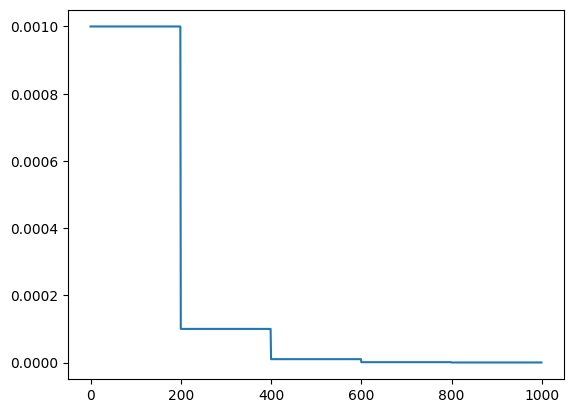

In [48]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

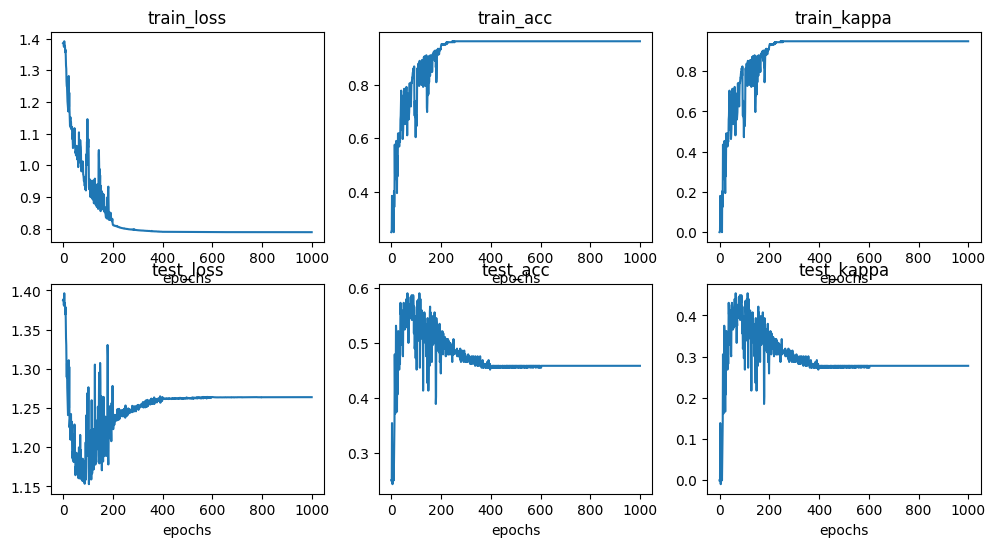

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

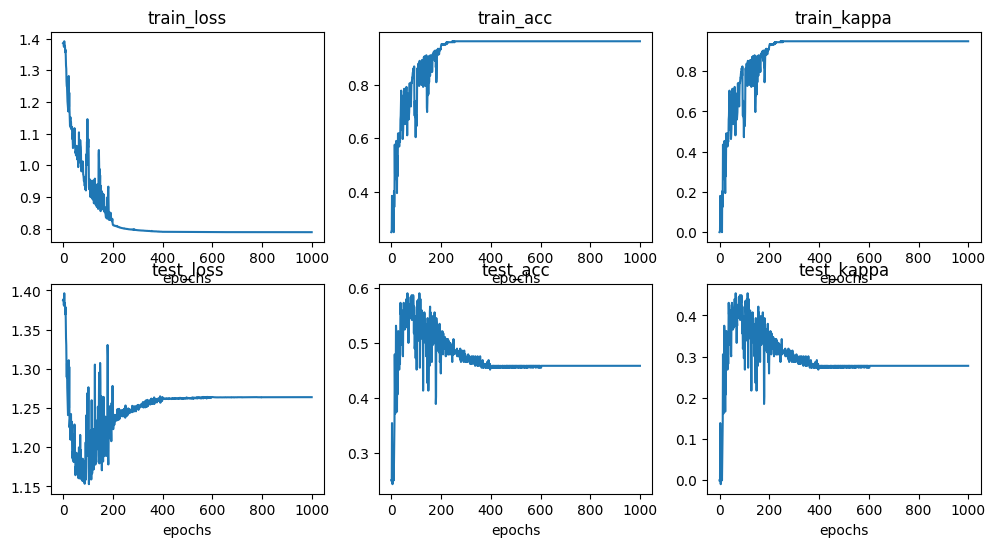

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()